In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import pandas as pd
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly
import emcee
import corner
from scipy.optimize import minimize
#from IPython.display import display, Math
import matplotlib as mpl
from multiprocessing.pool import Pool
from mcmc_functions import *
import pickle
import h5py
import glob
import os
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [3]:
#################################################
#   comparing ALL new MCMC fits on clean+bin
#################################################

In [10]:
#reading in old subselected dataframes
snztf18 = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/snztf18.csv')
sn19rwd = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn19rwd.csv')
sn20ano = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn20ano.csv',)
sn20bio = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn20bio.csv')
sn20ikq = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn20ikq.csv',)
sn20rsc = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn20rsc.csv',)
# sn21aezx = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn21aezx.csv')
sn21gno = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn21gno.csv')
sn21heh = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn21heh.csv')
sn21pb = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn21pb.csv')
sn21vgn = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn21vgn.csv')
sn22hnt = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn22hnt.csv')
sn22jpx = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn22jpx.csv')
sn22qzr = pd.read_csv('./mcmc_fp_results/raw_subselected_dfs/sn22qzr.csv')
sn22qzr.columns

Index(['JD', 'filter', 'mag', 'ztf_mag_lower', 'ztf_mag_upper',
       'atlas_mag_err', 'data_origin', 'norm_t', 'norm_m', 'max_ztf_err',
       'mag_err_all'],
      dtype='object')

In [11]:
#reading in new subselected dataframes
snztf18_n = pd.read_csv('cleaning/outputs/subselected_dfs/snztf18.csv')
sn19rwd_n = pd.read_csv('cleaning/outputs/subselected_dfs/sn19rwd.csv')
sn20ano_n = pd.read_csv('cleaning/outputs/subselected_dfs/sn20ano.csv')
sn20bio_n = pd.read_csv('cleaning/outputs/subselected_dfs/sn20bio.csv')
sn20ikq_n = pd.read_csv('cleaning/outputs/subselected_dfs/sn20ikq.csv')
sn20rsc_n = pd.read_csv('cleaning/outputs/subselected_dfs/sn20rsc.csv')
sn21gno_n = pd.read_csv('cleaning/outputs/subselected_dfs/sn21gno.csv')
sn21heh_n = pd.read_csv('cleaning/outputs/subselected_dfs/sn21heh.csv')
sn21pb_n = pd.read_csv('cleaning/outputs/subselected_dfs/sn21pb.csv')
sn21vgn_n = pd.read_csv('cleaning/outputs/subselected_dfs/sn21vgn.csv')
sn22hnt_n = pd.read_csv('cleaning/outputs/subselected_dfs/sn22hnt.csv')
sn22jpx_n = pd.read_csv('cleaning/outputs/subselected_dfs/sn22jpx.csv')
sn22qzr_n = pd.read_csv('cleaning/outputs/subselected_dfs/sn22qzr.csv')
sn22qzr_n.columns

Index(['mag', 'err', 'mjd', 'filter', 'JD', 'mag_err_all', 'norm_t', 'norm_m'], dtype='object')

In [12]:
r1_bool_dict = {
        "g": {"snztf18":True,
              "sn19rwd":True,
              "sn20bio":True,
              "sn21gno":True,
              "sn21heh":True,
              "sn21vgn":True,
              'sn22hnt':False,
              'sn22jpx':False,
              'sn22qzr':False,
              'sn20ano':True,
              'sn20ikq':True,
              'sn20rsc':True,
              'sn21pb':False},
        "r": {"snztf18":True,
              "sn19rwd":True,
              "sn20bio":True,
              "sn21gno":True,
              "sn21heh":True,
              "sn21vgn":True,
              'sn22hnt':True,
              'sn22jpx':True,
              'sn22qzr':True,
              'sn20ano':True,
              'sn20ikq':True,
              'sn20rsc':True,
              'sn21pb':True}
    }

r1_bool_dict_n = {
        "g": {"snztf18":True,
              "sn19rwd":True,
              'sn20ano':False,
              "sn20bio":True,
              'sn20ikq':True,
              'sn20rsc':True,
              "sn21gno":True,
              "sn21heh":False,
              'sn21pb':False,
              "sn21vgn":True,
              'sn22hnt':False,
              'sn22jpx':False,
              'sn22qzr':False,
              },
        "r": {"snztf18":True,
              "sn19rwd":True,
              'sn20ano':True,
              "sn20bio":False,
              'sn20ikq':True,
              'sn20rsc':True,
              "sn21gno":True,
              "sn21heh":False,
              'sn21pb':True,
              "sn21vgn":True,
              'sn22hnt':True,
              'sn22jpx':True,
              'sn22qzr':True,
              }
    }

In [13]:
df_str_list = ['snztf18','sn19rwd','sn20ano','sn20bio','sn20ikq','sn20rsc','sn21gno','sn21heh','sn21pb','sn21vgn','sn22hnt','sn22jpx','sn22qzr']
df_sub_ls = [snztf18,sn19rwd,sn20ano,sn20bio,sn20ikq,sn20rsc,sn21gno,sn21heh,sn21pb,sn21vgn,sn22hnt,sn22jpx,sn22qzr]
df_sub_ls_n = [snztf18_n,sn19rwd_n,sn20ano_n,sn20bio_n,sn20ikq_n,sn20rsc_n,sn21gno_n,sn21heh_n,sn21pb_n,sn21vgn_n,sn22hnt_n,sn22jpx_n,sn22qzr_n]
plot_names = ['ZTF18aalrxas', '19rwd', '20ano','20bio','20ikq','20rsc','21gno','21heh','21pb','21vgn','22hnt','22jpx','22qzr']
colors = ['#8dd3c7','#ff7f00','#bebada','#80b1d3','#fdb462','#b3de69','#fccde5','#6a3d9a','#bc80bd','#ccebc5','#ffed6f', '#fb8072', '#088F8F']

In [14]:
#old
g_chains = []
r_chains = []
for i in range(len(df_str_list)):
    save_dir = './mcmc_fp_results/flatchains/raw/'
    gf = save_dir+df_str_list[i]+'_g_flatchains.txt'
    rf = save_dir+df_str_list[i]+'_r_flatchains.txt'
    g_chains.append(gf)
    r_chains.append(rf)

#new
g_chains_n = []
r_chains_n = []
for i in range(len(df_str_list)):
    save_dir = 'cleaning/outputs/flatchains/'
    gf = save_dir+df_str_list[i]+'_g_flatchains.txt'
    rf = save_dir+df_str_list[i]+'_r_flatchains.txt'
    g_chains_n.append(gf)
    r_chains_n.append(rf)

In [15]:
def bestfit_recovery(filename, sub_df, band='', r1_bool=True, sn_id_band='test_g', replot=False, save=False):
    flat_samples = np.loadtxt(filename)
    if r1_bool:
        ndim = 7
    if not r1_bool:
        ndim = 5

    mcmc_results = []
    #retrieve the 16th/50th/84th percentile for each param and the lower/upper bounds on each
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        arr = [mcmc[1], q[0], q[1]]
        mcmc_results.append(arr)

    # making fit/autocorr/corner plots
    if band == 'g':
        g_df = sub_df[(sub_df['filter']=='ZTF_g') | (sub_df['filter']=='c')]
        x,y,yerr = np.array(g_df['norm_t']),np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
    if band == 'r':
        r_df = sub_df[(sub_df['filter']=='ZTF_r') | (sub_df['filter']=='o')]
        x,y,yerr = np.array(r_df['norm_t']),np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
    if replot:
        plot_mcmc_results(x, y, yerr, mcmc_results, flat_samples, r1=r1_bool, sn_band=sn_id_band, save=save)
        do_gw_autocorr_and_plot(filename, sn_id_band, save=save)

    return mcmc_results#,flat_samples

In [16]:
#creating bestfits for old, g
all_fits_g = [] # shape (13, 7, 3) (nobjects, nparams, npercentiles)
for i,file in enumerate(g_chains):
    fit = bestfit_recovery(file, df_sub_ls[i], band='g', r1_bool=r1_bool_dict['g'][df_str_list[i]],sn_id_band=df_str_list[i]+'_g')
    all_fits_g.append(fit)

In [17]:
#creating bestfits for old, r
all_fits_r = [] # shape (13, 7, 3) (nobjects, nparams, npercentiles)
for i,file in enumerate(r_chains):
    fit = bestfit_recovery(file, df_sub_ls[i], band='r', r1_bool=r1_bool_dict['r'][df_str_list[i]],sn_id_band=df_str_list[i]+'_r')
    all_fits_r.append(fit)

In [18]:
#creating bestfits for NEW, g
all_fits_g_n = [] # shape (13, 7, 3) (nobjects, nparams, npercentiles)
for i,file in enumerate(g_chains_n):
    fit = bestfit_recovery(file, df_sub_ls_n[i], band='g', r1_bool=r1_bool_dict_n['g'][df_str_list[i]],sn_id_band=df_str_list[i]+'_g')
    all_fits_g_n.append(fit)

In [19]:
#creating bestfits for NEW, r
all_fits_r_n = [] # shape (13, 7, 3) (nobjects, nparams, npercentiles)
for i,file in enumerate(r_chains_n):
    fit = bestfit_recovery(file, df_sub_ls_n[i], band='r', r1_bool=r1_bool_dict_n['r'][df_str_list[i]],sn_id_band=df_str_list[i]+'_r')
    all_fits_r_n.append(fit)

In [20]:
# FOR OLD

#the next two loops separate out the indivudal param values and append to list to do stats on them
best_fits_g,best_fits_r = [],[]
low_err_g, upp_err_g =[],[]
low_err_r, upp_err_r =[],[]
for i in range(len(all_fits_r)):
    #g band
    bestg = np.array(all_fits_g[i]).T[0]  #bestfit (50% ptile) values
    lowg = np.array(all_fits_g[i]).T[1]   #lower bound, 16% ptile
    highg =  np.array(all_fits_g[i]).T[2] #upper bound, 84% ptile
    best_fits_g.append(bestg)
    low_err_g.append(lowg)
    upp_err_g.append(highg)

    #r band
    bestr = np.array(all_fits_r[i]).T[0]  #bestfit (50% ptile) values
    lowr = np.array(all_fits_r[i]).T[1]   #lower bound, 16% ptile
    highr =  np.array(all_fits_r[i]).T[2] #upper bound, 84% ptile
    best_fits_r.append(bestr)
    low_err_r.append(lowr)
    upp_err_r.append(highr)

# formatting and saving best fits values in g and r
def format_arr(arr_in):
    if len(arr_in) == 5:
        arr = np.insert(arr_in, [0,3], np.nan)
    else:
        arr = arr_in
    return arr

best_fits_g_same_len = []
for i,arr in enumerate(best_fits_g):
    arr = format_arr(arr)
    best_fits_g_same_len.append(arr)

best_fits_r_same_len = []
for i,arr in enumerate(best_fits_r):
    arr = format_arr(arr)
    best_fits_r_same_len.append(arr)

low_err_g_same_len = []
for i,arr in enumerate(low_err_g):
    arr = format_arr(arr)
    low_err_g_same_len.append(arr)

low_err_r_same_len = []
for i,arr in enumerate(low_err_r):
    arr = format_arr(arr)
    low_err_r_same_len.append(arr)

upp_err_g_same_len = []
for i,arr in enumerate(upp_err_g):
    arr = format_arr(arr)
    upp_err_g_same_len.append(arr)

upp_err_r_same_len = []
for i,arr in enumerate(upp_err_r):
    arr = format_arr(arr)
    upp_err_r_same_len.append(arr)

#saving to df
best_fits_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
best_fits_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
bestfit_df = pd.DataFrame(columns=best_fits_cols_g, data=best_fits_g_same_len)
bestfit_r_df = pd.DataFrame(columns=best_fits_cols_r, data=best_fits_r_same_len)
bestfit_df.insert(0,'SN_ID', df_str_list)
bestfit_df = pd.concat([bestfit_df,bestfit_r_df], axis=1)

m_a2g_a1g_ls, m_a2r_a1r_ls, m_a1g_a1r_ls, m_a2g_a2r_ls = [],[],[],[]
for i,df in enumerate(df_sub_ls):
    df_str = df_str_list[i]

    #gband
    g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
    x_plt_g = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)
    sn_g = bestfit_df.loc[:,bestfit_df.columns.str[-2:]=='_g'].loc[i]
    sn_g = sn_g.loc[sn_g.notna()].to_numpy()
    a1_g, a2_g = bestfit_df['a1_g'].loc[i], bestfit_df['a2_g'].loc[i]
    a1crit_g = np.abs(x_plt_g - a1_g).argmin()
    a2crit_g = np.abs(x_plt_g - a2_g).argmin()

    mags_g = np.array([model(sn_g, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt_g])
    a1_gmag = mags_g[a1crit_g] 
    a2_gmag = mags_g[a2crit_g]

    #rband
    r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]
    x_plt_r = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)
    sn_r = bestfit_df.loc[:,bestfit_df.columns.str[-2:]=='_r'].loc[i]
    sn_r = sn_r.loc[sn_r.notna()].to_numpy()
    a1_r, a2_r = bestfit_df['a1_r'].loc[i], bestfit_df['a2_r'].loc[i]
    a1crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a1_r).argmin()]
    a2crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a2_r).argmin()]
    
    mags_r = np.array([model(sn_r, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt_r])
    a1_rmag = mags_r[a1crit_r]
    a2_rmag = mags_r[a2crit_r]

    #calcing quants
    m_a2g_a1g = a2_gmag - a1_gmag
    m_a2r_a1r = a2_rmag - a1_rmag
    m_a1g_a1r = a1_gmag - a1_rmag
    m_a2g_a2r = a2_gmag - a2_rmag

    #appending
    m_a2g_a1g_ls.append(m_a2g_a1g)
    m_a2r_a1r_ls.append(m_a2r_a1r[0])
    m_a1g_a1r_ls.append(m_a1g_a1r[0])
    m_a2g_a2r_ls.append(m_a2g_a2r[0])

bestfit_df['mag_a2g-a1g'] = m_a2g_a1g_ls
bestfit_df['mag_a2r-a1r'] = m_a2r_a1r_ls
bestfit_df['mag_a1g-a1r'] = m_a1g_a1r_ls
bestfit_df['mag_a2g-a2r'] = m_a2g_a2r_ls
bestfit_df

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,m3_r,b2_r,a1_r,a2_r,log_f_r,mag_a2g-a1g,mag_a2r-a1r,mag_a1g-a1r,mag_a2g-a2r
0,snztf18,-1.453288,0.268554,-0.052926,-3.864192,6.714141,13.107969,-3.746322,-1.653940,0.115683,-0.073302,-2.350598,7.663041,15.613060,-3.564006,1.716062,0.917334,-0.598606,0.200123
1,sn19rwd,-0.979590,0.142178,-0.049146,-1.921088,8.261812,14.163972,-2.701529,-0.514944,0.091144,-0.029224,-1.386172,8.728792,13.820153,-1.902896,0.835932,0.463921,-0.152970,0.219041
2,sn20ano,-0.606980,0.382998,-0.088906,-5.203419,9.180605,14.371975,-0.533924,-0.715000,0.299137,-0.084340,-4.335608,8.722938,13.916714,-3.500523,1.987588,1.552494,0.038507,0.473601
3,sn20bio,-0.679592,0.187333,-0.183369,-2.579680,9.410125,14.717309,1.364686,-0.805282,0.282817,-0.133987,-3.897599,9.193014,16.188675,-3.466265,0.992863,1.976614,0.480072,-0.503679
4,sn20ikq,-1.107506,0.107934,-0.003755,-1.651887,2.241731,14.641405,-1.418653,-0.960401,0.034754,-0.003679,-0.828949,1.582649,15.622305,-1.472611,1.332726,0.487833,-0.630919,0.213974
5,sn20rsc,-1.542456,0.364869,-0.036975,-5.069791,10.071302,17.606733,-1.621135,-0.962749,0.242947,-0.062612,-3.515344,10.101722,16.254400,0.209470,2.747805,1.494123,-0.333023,0.920660
6,sn21gno,-1.589472,0.151964,-0.089391,-2.115394,9.798067,13.929084,-1.423370,-1.115765,0.119778,-0.105575,-1.871648,10.381562,13.481051,-2.602094,0.627611,0.368723,-0.000500,0.258387
7,sn21heh,-1.018082,0.165181,-0.073015,-2.609369,2.694032,14.985388,-1.329173,-0.433238,0.137601,-0.059142,-2.657557,4.501014,13.922081,-2.373261,2.026297,1.296023,-0.123179,0.607096
8,sn21pb,NaN,0.231304,-0.117904,-3.303867,NaN,13.760906,-1.540608,-0.837429,0.150080,-0.125843,-2.440361,8.766434,14.156986,-1.762168,0.896659,0.808662,0.106624,0.194621
9,sn21vgn,-0.857860,0.206177,-0.064994,-2.372771,7.236515,13.527217,-1.622646,-1.602391,0.166318,-0.059288,-2.048997,7.264507,13.407664,-0.335258,1.296530,1.020132,-0.040556,0.235842


In [42]:
#saving lower bound errs to df
low_err_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
low_err_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
low_err_df = pd.DataFrame(columns=low_err_cols_g, data=low_err_g_same_len)
low_err_r_df = pd.DataFrame(columns=low_err_cols_r, data=low_err_r_same_len)
low_err_df.insert(0,'SN_ID', df_str_list)
low_err_df_old = pd.concat([low_err_df,low_err_r_df], axis=1)
print(low_err_df_old,'\n')

#saving upper bound errs to df
upp_err_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
upp_err_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
upp_err_df = pd.DataFrame(columns=upp_err_cols_g, data=upp_err_g_same_len)
upp_err_r_df = pd.DataFrame(columns=upp_err_cols_r, data=upp_err_r_same_len)
upp_err_df.insert(0,'SN_ID', df_str_list)
upp_err_df_old = pd.concat([upp_err_df,upp_err_r_df], axis=1)
print(upp_err_df_old)

      SN_ID      m1_g      m2_g      m3_g      b2_g      a1_g      a2_g  \
0   snztf18  0.379121  0.010618  0.006352  0.082056  0.130518  0.110084   
1   sn19rwd  0.688553  0.018286  0.108145  0.182200  0.153033  0.524296   
2   sn20ano  0.823853  0.024092  0.020993  0.177081  0.162335  0.382983   
3   sn20bio  0.762030  0.060297  0.047711  0.939093  1.239651  0.857830   
4   sn20ikq  0.497741  0.006167  0.006712  0.272717  0.372488  0.487594   
5   sn20rsc  0.228686  0.026169  0.046032  0.285469  0.139646  0.456813   
6   sn21gno  0.294852  0.036593  0.016060  0.983540  0.460867  0.459600   
7   sn21heh  0.613739  0.028667  0.026871  0.432895  2.116114  0.420004   
8    sn21pb       NaN  0.048397  0.029582  0.536783       NaN  0.192143   
9   sn21vgn  0.104834  0.027370  0.014290  0.252994  0.135922  0.378467   
10  sn22hnt       NaN  0.047617  0.016797  0.384028       NaN  0.259393   
11  sn22jpx       NaN  0.048868  0.028057  1.079308       NaN  1.177454   
12  sn22qzr       NaN  0.

In [21]:
## CREATING DF FOR NEW MCMC

#the next two loops separate out the indivudal param values and append to list to do stats on them
#the next two loops separate out the indivudal param values and append to list to do stats on them
best_fits_g_n,best_fits_r_n = [],[]
low_err_g_n, upp_err_g_n =[],[]
low_err_r_n, upp_err_r_n =[],[]
for i in range(len(all_fits_r_n)):
    #g band
    bestg = np.array(all_fits_g_n[i]).T[0]  #bestfit (50% ptile) values
    lowg = np.array(all_fits_g_n[i]).T[1]   #lower bound, 16% ptile
    highg =  np.array(all_fits_g_n[i]).T[2] #upper bound, 84% ptile
    best_fits_g_n.append(bestg)
    low_err_g_n.append(lowg)
    upp_err_g_n.append(highg)

    #r band
    bestr = np.array(all_fits_r_n[i]).T[0]  #bestfit (50% ptile) values
    lowr = np.array(all_fits_r_n[i]).T[1]   #lower bound, 16% ptile
    highr =  np.array(all_fits_r_n[i]).T[2] #upper bound, 84% ptile
    best_fits_r_n.append(bestr)
    low_err_r_n.append(lowr)
    upp_err_r_n.append(highr)

best_fits_g_same_len_n = []
for i,arr in enumerate(best_fits_g_n):
    arr = format_arr(arr)
    best_fits_g_same_len_n.append(arr)

best_fits_r_same_len_n = []
for i,arr in enumerate(best_fits_r_n):
    arr = format_arr(arr)
    best_fits_r_same_len_n.append(arr)

low_err_g_same_len_n = []
for i,arr in enumerate(low_err_g_n):
    arr = format_arr(arr)
    low_err_g_same_len_n.append(arr)

low_err_r_same_len_n = []
for i,arr in enumerate(low_err_r_n):
    arr = format_arr(arr)
    low_err_r_same_len_n.append(arr)

upp_err_g_same_len_n = []
for i,arr in enumerate(upp_err_g_n):
    arr = format_arr(arr)
    upp_err_g_same_len_n.append(arr)

upp_err_r_same_len_n = []
for i,arr in enumerate(upp_err_r_n):
    arr = format_arr(arr)
    upp_err_r_same_len_n.append(arr)


#saving to df
best_fits_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
best_fits_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
bestfit_df_n = pd.DataFrame(columns=best_fits_cols_g, data=best_fits_g_same_len_n)
bestfit_r_df_n = pd.DataFrame(columns=best_fits_cols_r, data=best_fits_r_same_len_n)
bestfit_df_n.insert(0,'SN_ID', df_str_list)
bestfit_df_new = pd.concat([bestfit_df_n,bestfit_r_df_n], axis=1)

#same sn, same lc, same filters, diff params
bestfit_df_new['a2g-a1g'] = bestfit_df_new['a2_g'] - bestfit_df_new['a1_g']
bestfit_df_new['a2r-a1r'] = bestfit_df_new['a2_r'] - bestfit_df_new['a1_r']
#same sn, diff lc, diff filters, same params
bestfit_df_new['a1g-a1r'] = bestfit_df_new['a1_g'] - bestfit_df_new['a1_r']
bestfit_df_new['a2g-a2r'] = bestfit_df_new['a2_g'] - bestfit_df_new['a2_r']

m_a2g_a1g_ls_n, m_a2r_a1r_ls_n, m_a1g_a1r_ls_n, m_a2g_a2r_ls_n = [],[],[],[]
for i,df in enumerate(df_sub_ls_n):
    df_str = df_str_list[i]

    #gband
    g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
    x_plt_g = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)
    sn_g = bestfit_df_new.loc[:,bestfit_df_new.columns.str[-2:]=='_g'].loc[i]
    sn_g = sn_g.loc[sn_g.notna()].to_numpy()
    a1_g, a2_g = bestfit_df_new['a1_g'].loc[i], bestfit_df_new['a2_g'].loc[i]
    a1crit_g = np.abs(x_plt_g - a1_g).argmin()
    a2crit_g = np.abs(x_plt_g - a2_g).argmin()

    mags_g = np.array([model(sn_g, v, r1=r1_bool_dict_n['g'][df_str]) for v in x_plt_g])
    a1_gmag = mags_g[a1crit_g] 
    a2_gmag = mags_g[a2crit_g]

    #rband
    r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]
    x_plt_r = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)
    sn_r = bestfit_df_new.loc[:,bestfit_df_new.columns.str[-2:]=='_r'].loc[i]
    sn_r = sn_r.loc[sn_r.notna()].to_numpy()
    a1_r, a2_r = bestfit_df_new['a1_r'].loc[i], bestfit_df_new['a2_r'].loc[i]
    a1crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a1_r).argmin()]
    a2crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a2_r).argmin()]
    
    mags_r = np.array([model(sn_r, v, r1=r1_bool_dict_n['r'][df_str]) for v in x_plt_r])
    a1_rmag = mags_r[a1crit_r]
    a2_rmag = mags_r[a2crit_r]

    #calcing quants
    m_a2g_a1g = a2_gmag - a1_gmag
    m_a2r_a1r = a2_rmag - a1_rmag
    m_a1g_a1r = a1_gmag - a1_rmag
    m_a2g_a2r = a2_gmag - a2_rmag

    #appending
    m_a2g_a1g_ls_n.append(m_a2g_a1g)
    m_a2r_a1r_ls_n.append(m_a2r_a1r[0])
    m_a1g_a1r_ls_n.append(m_a1g_a1r[0])
    m_a2g_a2r_ls_n.append(m_a2g_a2r[0])

bestfit_df_new['mag_a2g-a1g'] = m_a2g_a1g_ls_n
bestfit_df_new['mag_a2r-a1r'] = m_a2r_a1r_ls_n
bestfit_df_new['mag_a1g-a1r'] = m_a1g_a1r_ls_n
bestfit_df_new['mag_a2g-a2r'] = m_a2g_a2r_ls_n
bestfit_df_new

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,...,a2_r,log_f_r,a2g-a1g,a2r-a1r,a1g-a1r,a2g-a2r,mag_a2g-a1g,mag_a2r-a1r,mag_a1g-a1r,mag_a2g-a2r
0,snztf18,-0.441088,0.339993,-0.141367,-4.072793,7.646995,14.073731,0.044069,-0.473561,0.229834,...,13.448832,-3.145814,6.426736,5.188517,-0.613320,0.624899,2.183416,1.189998,-0.254795,0.738623
1,sn19rwd,-0.730247,0.137662,-0.052702,-1.862211,8.372645,14.235884,-2.821739,-0.318845,0.099282,...,13.540573,-1.339863,5.863239,4.482031,-0.685897,0.695311,0.806383,0.443329,-0.145208,0.217845
2,sn20ano,NaN,0.385992,-0.110979,-5.028698,NaN,14.640632,-1.537835,-1.029100,0.312861,...,14.149096,-3.356272,NaN,5.083730,NaN,0.491536,2.099795,1.586013,0.038902,0.552683
3,sn20bio,-0.999993,0.250002,-0.125014,-2.749999,7.025532,13.512784,-1.999992,NaN,0.214746,...,15.815197,-1.964035,6.487253,NaN,NaN,-2.302413,1.621480,1.476748,0.078507,0.223239
4,sn20ikq,-0.835783,0.106653,-0.003670,-1.349933,0.497618,12.767812,-1.587851,-0.148042,0.042614,...,15.384609,-2.734686,12.270194,13.733467,-1.153524,-2.616797,1.306697,0.585089,-0.592735,0.128873
5,sn20rsc,-1.270084,0.372455,-0.116215,-4.467845,8.112777,14.829597,-1.038237,-0.685342,0.203831,...,16.489876,-0.131960,6.716820,8.176875,-0.200224,-1.660279,2.501129,1.665301,-0.057813,0.778014
6,sn21gno,-0.844909,0.161112,-0.094699,-2.240817,9.387621,13.996058,-1.304933,-0.873202,0.128828,...,13.595428,-2.445209,4.608437,3.080724,-1.127084,0.400630,0.741113,0.392669,-0.093632,0.254812
7,sn21heh,NaN,0.209026,-0.058219,-2.181023,NaN,13.782958,-1.665501,NaN,0.137836,...,13.950519,-1.849520,NaN,NaN,NaN,-0.167561,1.623349,1.349418,0.344078,0.618008
8,sn21pb,NaN,0.344176,-0.096742,-4.582536,NaN,14.087840,-1.609341,-0.713595,0.243400,...,14.370467,-1.991667,NaN,3.896252,NaN,-0.282627,1.063505,0.946219,0.066044,0.183330
9,sn21vgn,-1.021266,0.187590,-0.065924,-2.345575,7.061713,14.015841,-2.613281,-1.023433,0.176880,...,13.464792,-2.118438,6.954128,6.129850,-0.273229,0.551049,1.302384,1.078547,-0.007532,0.216306


In [43]:
#saving lower bound errs to df
low_err_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
low_err_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
low_err_df_n = pd.DataFrame(columns=low_err_cols_g, data=low_err_g_same_len_n)
low_err_r_df_n = pd.DataFrame(columns=low_err_cols_r, data=low_err_r_same_len_n)
low_err_df_n.insert(0,'SN_ID', df_str_list)
low_err_df_new = pd.concat([low_err_df_n,low_err_r_df_n], axis=1)
print(low_err_df_new,'\n')

#saving upper bound errs to df
upp_err_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
upp_err_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
upp_err_df_n = pd.DataFrame(columns=upp_err_cols_g, data=upp_err_g_same_len_n)
upp_err_r_df_n = pd.DataFrame(columns=upp_err_cols_r, data=upp_err_r_same_len_n)
upp_err_df_n.insert(0,'SN_ID', df_str_list)
upp_err_df_new = pd.concat([upp_err_df_n,upp_err_r_df_n], axis=1)
print(upp_err_df_new)

      SN_ID      m1_g      m2_g      m3_g      b2_g      a1_g      a2_g  \
0   snztf18  0.806254  0.067018  0.048246  0.511906  0.941043  0.339788   
1   sn19rwd  0.736526  0.018467  0.133298  0.189978  0.233242  0.591560   
2   sn20ano       NaN  0.023773  0.020643  0.188917       NaN  0.369955   
3   sn20bio  0.000088  0.000078  0.000097  0.000082  0.000104  0.000110   
4   sn20ikq  0.212664  0.005249  0.008378  0.293407  0.213888  0.436833   
5   sn20rsc  0.433178  0.043579  0.089217  0.259480  0.273315  1.024392   
6   sn21gno  0.768763  0.043492  0.018519  1.399644  0.921182  0.462616   
7   sn21heh       NaN  0.022087  0.009968  0.252838       NaN  0.391498   
8    sn21pb       NaN  0.074646  0.028060  0.505811       NaN  0.295465   
9   sn21vgn  0.159696  0.030960  0.010436  0.219472  0.183293  0.360330   
10  sn22hnt       NaN  0.041411  0.022059  0.343806       NaN  0.265291   
11  sn22jpx       NaN  0.048498  0.057591  0.980010       NaN  1.351424   
12  sn22qzr       NaN  0.

In [22]:
old_mjd_at_a2 = [2458236.8568866,2458768.8084491,2458877.9690046,2458885.095686,2458981.89003,2459085.9696875,2459298.8947569,2459310.7228241,2459227.012787,2459443.808147,2459689.7834028,2459719.590462,2459807.898125]
new_mjd_at_a2 = [2458236.9182920144,2458768.8086748,2458877.7548206,2458885.101305,2458983.85990625,2459087.9379012333,2459298.8947569,2459310.697662,2459225.9025231,2459443.8168685,2459688.8438889,2459719.589881,2459807.898125]

In [81]:
def make_g_band_comparison(df, df_clean, df_str, sn_fits_g_old, sn_fits_g_new, old_a2_mjd, new_a2_mjd,color):
    gridspec = dict(hspace=0.0)
    fig, ax = plt.subplots(2,1, figsize=(6,8),sharex=True,gridspec_kw=gridspec)

    #########plotting OLD
    g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
    t_mjd = np.array(g_df['norm_t'])-15+old_a2_mjd
    x_plt = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)

    best = np.array(sn_fits_g_old).T[0] #bestfit values
    lower_bound = np.array(sn_fits_g_old).T[0] - np.array(sn_fits_g_old).T[1] #50th ptile - diff_16ptile
    upper_bound = np.array(sn_fits_g_old).T[0] + np.array(sn_fits_g_old).T[2] #50th ptile + diff_84ptile

    #plotting mcmc results
    ax[0].plot(x_plt-15+old_a2_mjd, np.array([model(best, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt]), c=color, label=df_str+'_old', linewidth=2.25)# linestyle=ls[i])
    lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
    upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
    ax[0].fill_between(x_plt-15+old_a2_mjd, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)

    ax[0].axvline(bestfit_df[bestfit_df['SN_ID']==df_str]['a1_g'].iloc[0]-15+old_a2_mjd,
                color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
    ax[0].axvline(bestfit_df[bestfit_df['SN_ID']==df_str]['a2_g'].iloc[0]-15+old_a2_mjd,
                color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

    #plotting ztf data
    dets = (g_df['mag_err_all']<9999)
    uplims = ~dets
    x = np.array(g_df.loc[dets,'norm_t'])-15+old_a2_mjd
    y = np.array(g_df.loc[dets,'norm_m'])
    yerr = np.array(g_df.loc[dets,'mag_err_all'])
    xup, yup = np.array(g_df.loc[uplims,'norm_t'])-15+old_a2_mjd, np.array(g_df.loc[uplims,'norm_m'])
    ax[0].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0) #ztf errors,
    ax[0].scatter(xup, yup, linestyle='', marker='v', color='gray', alpha=0.1, s=65, zorder=0)

    ax[0].set_ylim(6,-4)
    # ax[0].invert_yaxis()
    
    ax[0].xaxis.set_minor_locator(AutoMinorLocator())
    ax[0].yaxis.set_minor_locator(AutoMinorLocator())
    ax[0].tick_params(which="both",top=True, labeltop=False, bottom=True, labelbottom=False, left=True, right=True, direction="in",zorder=0)

    plt.annotate('unproc',xy=(0.76,1.88),xycoords='axes fraction',color='gray',fontsize=14)
    plt.annotate('m1='+str(round(bestfit_df[bestfit_df['SN_ID']==df_str]['m1_g'].iloc[0],3))+'\n'+'m2='+str(round(bestfit_df[bestfit_df['SN_ID']==df_str]['m2_g'].iloc[0],3)),
                 xy=(0.76,1.1),xycoords='axes fraction',color='gray',fontsize=14)


    # #######plotting NEW
    g_df = df_clean[(df_clean['filter']=='ZTF_g') | (df_clean['filter']=='c')]
    t_mjd = np.array(g_df['norm_t'])-15+new_a2_mjd
    x_plt = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)

    best = np.array(sn_fits_g_new).T[0] #bestfit values
    lower_bound = np.array(sn_fits_g_new).T[0] - np.array(sn_fits_g_new).T[1] #50th ptile - diff_16ptile
    upper_bound = np.array(sn_fits_g_new).T[0] + np.array(sn_fits_g_new).T[2] #50th ptile + diff_84ptile

    #plotting mcmc results
    ax[1].plot(x_plt-15+new_a2_mjd, np.array([model(best, v, r1=r1_bool_dict_n['g'][df_str]) for v in x_plt]), c=color, label=df_str+'_new', linewidth=2.25)# linestyle=ls[i])
    lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict_n['g'][df_str]) for v in x_plt])
    upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict_n['g'][df_str]) for v in x_plt])
    ax[1].fill_between(x_plt-15+new_a2_mjd, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)

    ax[1].axvline(bestfit_df_new[bestfit_df_new['SN_ID']==df_str]['a1_g'].iloc[0]-15+new_a2_mjd,
                        color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
    ax[1].axvline(bestfit_df_new[bestfit_df_new['SN_ID']==df_str]['a2_g'].iloc[0]-15+new_a2_mjd,
                color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

    #plotting ztf data
    dets = (g_df['mag_err_all']<9999)
    uplims = ~dets
    x = np.array(g_df.loc[dets,'norm_t'])-15+old_a2_mjd
    y = np.array(g_df.loc[dets,'norm_m'])
    yerr = np.array(g_df.loc[dets,'mag_err_all'])
    xup, yup = np.array(g_df.loc[uplims,'norm_t'])-15+old_a2_mjd, np.array(g_df.loc[uplims,'norm_m'])
    ax[1].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0) #ztf errors,
    ax[1].scatter(xup, yup, linestyle='', marker='v', color='gray', alpha=0.1, s=65, zorder=0)

    ax[1].set_ylim(6,-4)
    # ax[1].invert_yaxis()

    ax[1].xaxis.set_minor_locator(AutoMinorLocator())
    ax[1].yaxis.set_minor_locator(AutoMinorLocator())
    ax[1].tick_params(which="both",top=True, labeltop=False, bottom=True, labelbottom=True, left=True, right=True, direction="in",zorder=0)

    plt.annotate('cleaned+binned',xy=(0.66,0.88),xycoords='axes fraction',color='gray',fontsize=14)
    plt.annotate('m1='+str(round(bestfit_df_new[bestfit_df_new['SN_ID']==df_str]['m1_g'].iloc[0],3))+'\n'+'m2='+str(round(bestfit_df_new[bestfit_df_new['SN_ID']==df_str]['m2_g'].iloc[0],3)),
                 xy=(0.76,0.1),xycoords='axes fraction',color='gray',fontsize=14)

    plt.suptitle(df_str+' (g-band)')
    plt.tight_layout()

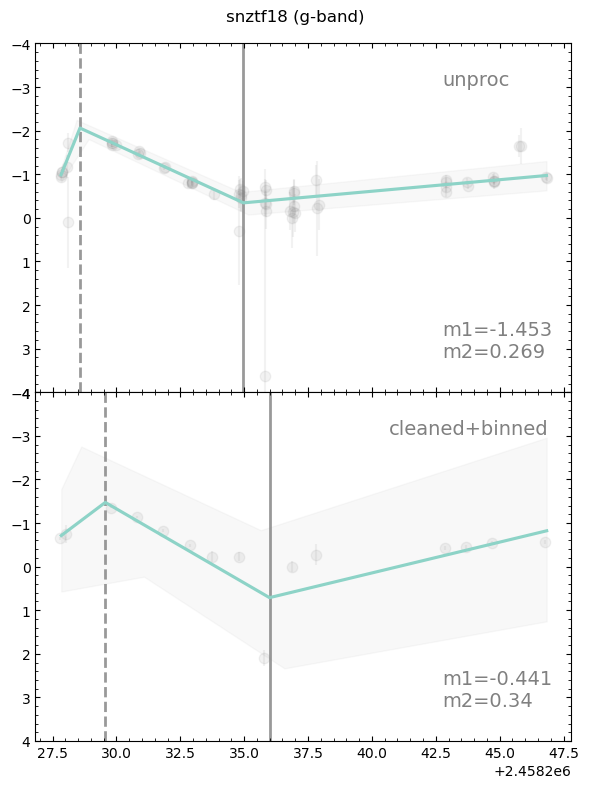

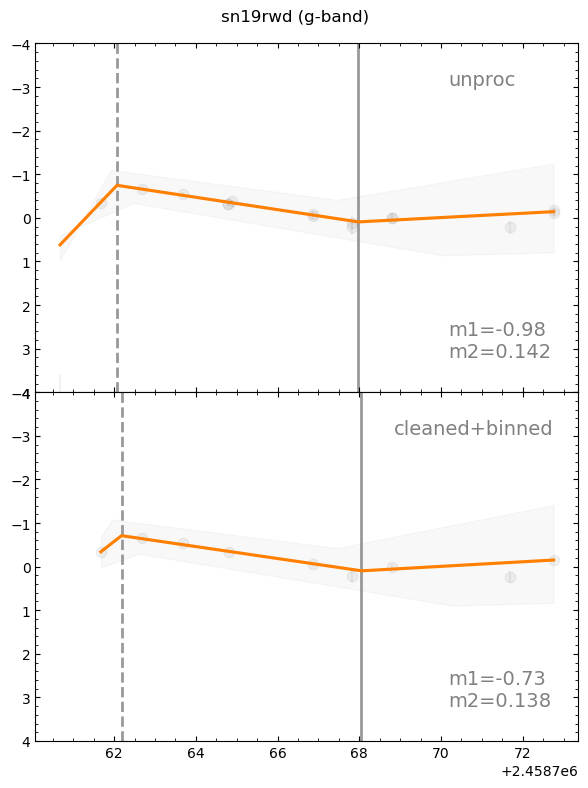

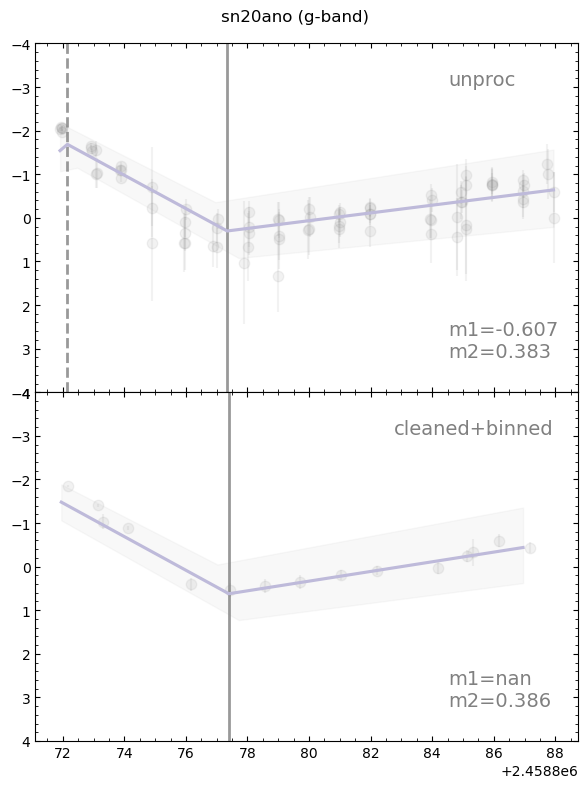

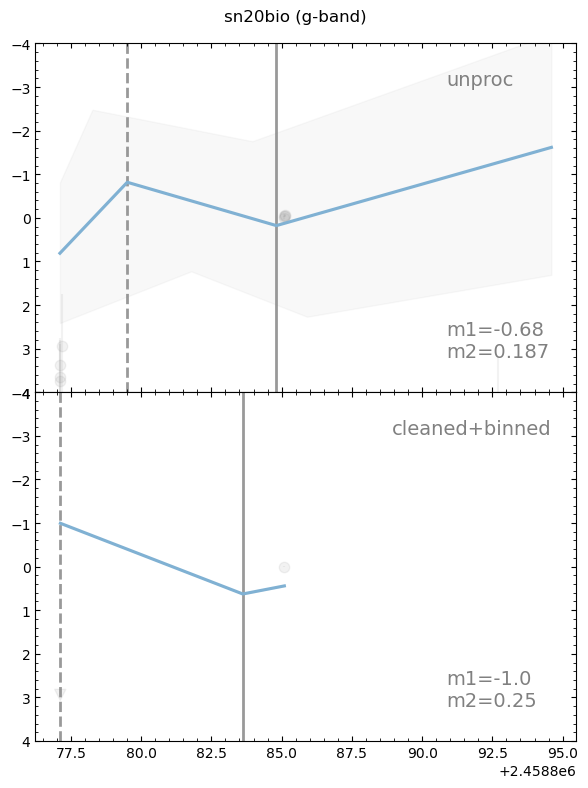

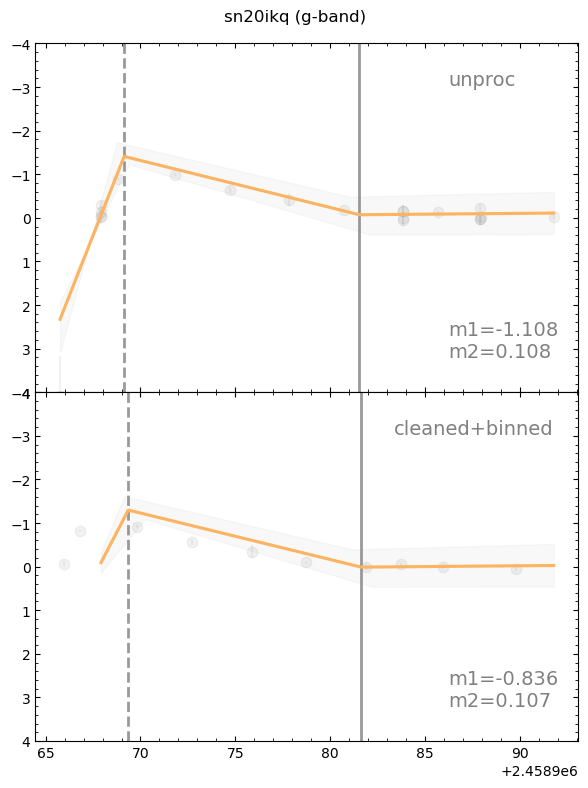

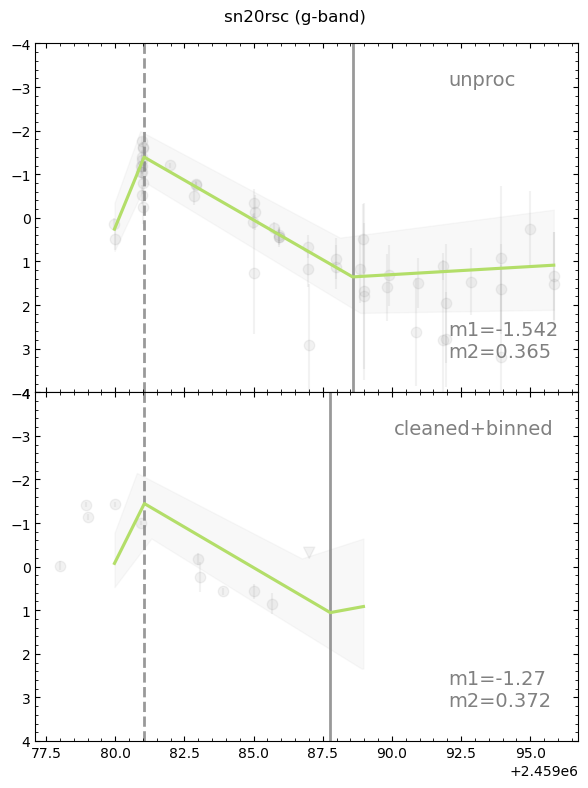

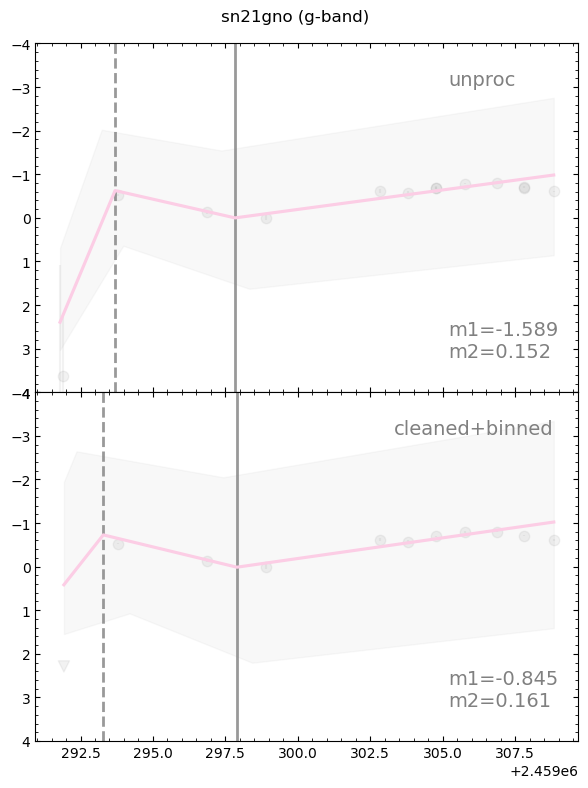

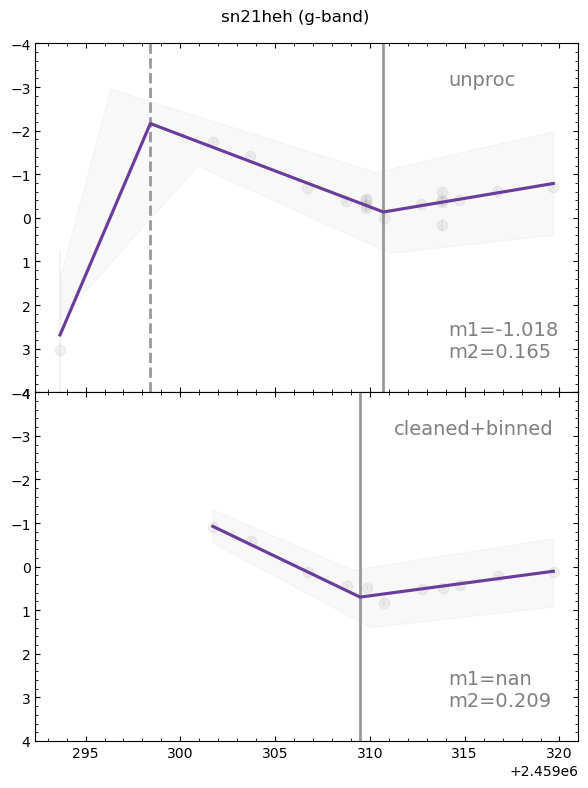

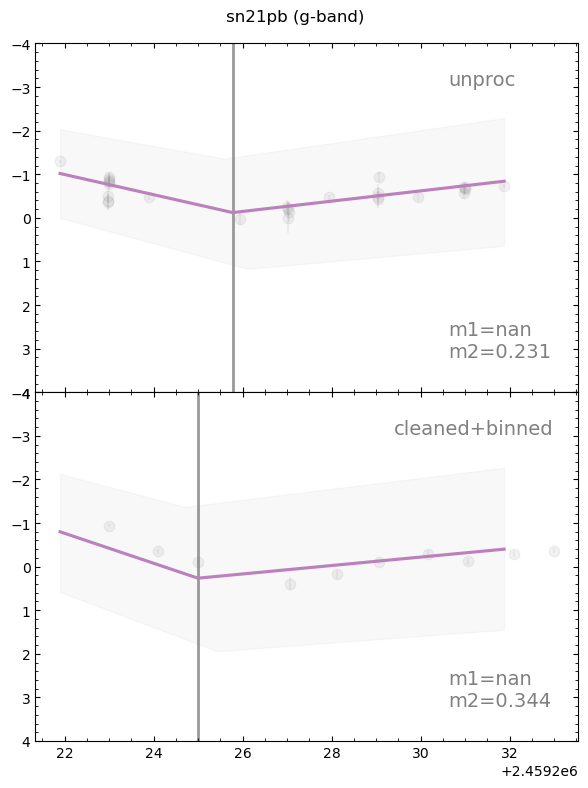

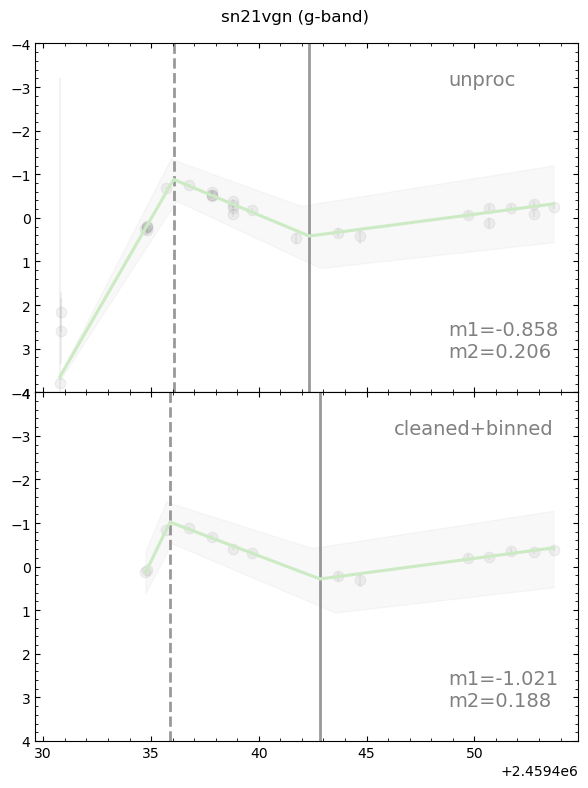

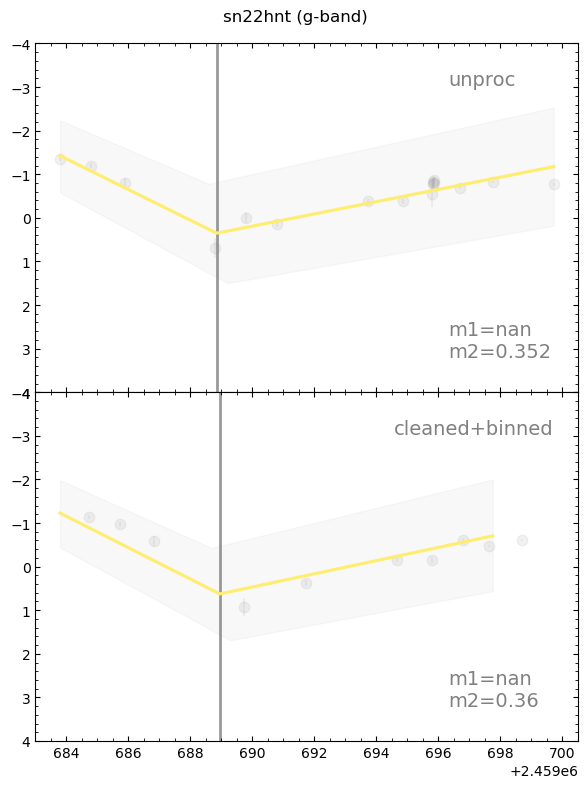

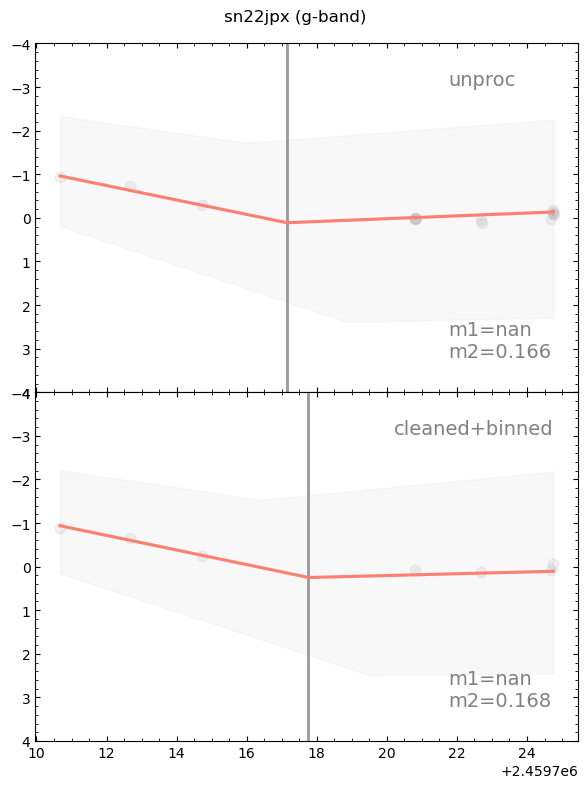

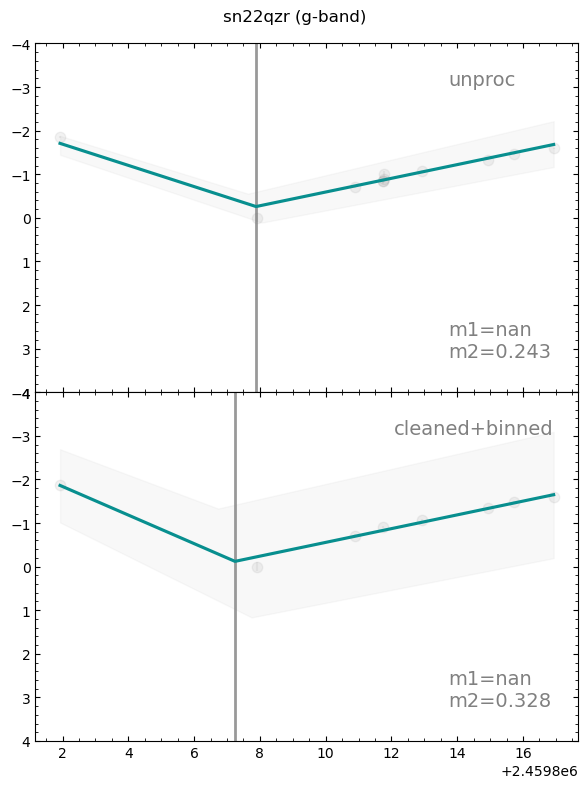

In [170]:
for i,df in enumerate(df_sub_ls):
    make_g_band_comparison(df, df_sub_ls_n[i], df_str_list[i], all_fits_g[i], all_fits_g_n[i], old_mjd_at_a2[i], new_mjd_at_a2[i], colors[i])

In [82]:
def make_r_band_comparison(df, df_clean, df_str, sn_fits_r_old, sn_fits_r_new, old_a2_mjd, new_a2_mjd, color):
    gridspec = dict(hspace=0.0)
    fig, ax = plt.subplots(2,1, figsize=(6,8),sharex=True,gridspec_kw=gridspec)

    #########plotting OLD
    r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]
    t_mjd = np.array(r_df['norm_t'])-15+old_a2_mjd
    x_plt = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)

    best = np.array(sn_fits_r_old).T[0] #bestfit values
    lower_bound = np.array(sn_fits_r_old).T[0] - np.array(sn_fits_r_old).T[1] #50th ptile - diff_16ptile
    upper_bound = np.array(sn_fits_r_old).T[0] + np.array(sn_fits_r_old).T[2] #50th ptile + diff_84ptile

    #plotting mcmc results
    ax[0].plot(x_plt-15+old_a2_mjd, np.array([model(best, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt]), c=color, label=df_str+'_old', linewidth=2.25)# linestyle=ls[i])
    lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
    upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
    ax[0].fill_between(x_plt-15+old_a2_mjd, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)

    ax[0].axvline(bestfit_df[bestfit_df['SN_ID']==df_str]['a1_r'].iloc[0]-15+old_a2_mjd,
                color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
    ax[0].axvline(bestfit_df[bestfit_df['SN_ID']==df_str]['a2_r'].iloc[0]-15+old_a2_mjd,
                color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

    #plotting ztf data
    dets = (r_df['mag_err_all']<9999)
    uplims = ~dets
    x = np.array(r_df.loc[dets,'norm_t'])-15+old_a2_mjd
    y = np.array(r_df.loc[dets,'norm_m'])
    yerr = np.array(r_df.loc[dets,'mag_err_all'])
    xup, yup = np.array(r_df.loc[uplims,'norm_t'])-15+old_a2_mjd, np.array(r_df.loc[uplims,'norm_m'])
    ax[0].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0) #ztf errors,
    ax[0].scatter(xup, yup, linestyle='', marker='v', color='gray', alpha=0.1, s=65, zorder=0)

    ax[0].set_ylim(4,-4)
    # ax[0].invert_yaxis()
    ax[0].set_title('Old MCMC Fits')

    ax[0].xaxis.set_minor_locator(AutoMinorLocator())
    ax[0].yaxis.set_minor_locator(AutoMinorLocator())
    ax[0].tick_params(which="both",top=True, labeltop=False, bottom=True, labelbottom=False, left=True, right=True, direction="in",zorder=0)

    plt.annotate('unproc',xy=(0.76,1.88),xycoords='axes fraction',color='gray',fontsize=14)
    plt.annotate('m1='+str(round(bestfit_df[bestfit_df['SN_ID']==df_str]['m1_r'].iloc[0],3))+'\n'+'m2='+str(round(bestfit_df[bestfit_df['SN_ID']==df_str]['m2_r'].iloc[0],3)),
                 xy=(0.76,1.1),xycoords='axes fraction',color='gray',fontsize=14)



    # #######plotting NEW
    r_df = df_clean[(df_clean['filter']=='ZTF_r') | (df_clean['filter']=='o')]
    t_mjd = np.array(r_df['norm_t'])-15+new_a2_mjd
    x_plt = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)

    best = np.array(sn_fits_r_new).T[0] #bestfit values
    lower_bound = np.array(sn_fits_r_new).T[0] - np.array(sn_fits_r_new).T[1] #50th ptile - diff_16ptile
    upper_bound = np.array(sn_fits_r_new).T[0] + np.array(sn_fits_r_new).T[2] #50th ptile + diff_84ptile

    #plotting mcmc results
    ax[1].plot(x_plt-15+new_a2_mjd, np.array([model(best, v, r1=r1_bool_dict_n['r'][df_str]) for v in x_plt]), c=color, label=df_str+'_new', linewidth=2.25)# linestyle=ls[i])
    lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict_n['r'][df_str]) for v in x_plt])
    upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict_n['r'][df_str]) for v in x_plt])
    ax[1].fill_between(x_plt-15+new_a2_mjd, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)

    ax[1].axvline(bestfit_df_new[bestfit_df_new['SN_ID']==df_str]['a1_r'].iloc[0]-15+new_a2_mjd,
                        color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
    ax[1].axvline(bestfit_df_new[bestfit_df_new['SN_ID']==df_str]['a2_r'].iloc[0]-15+new_a2_mjd,
                color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

    #plotting ztf data
    dets = (r_df['mag_err_all']<9999)
    uplims = ~dets
    x = np.array(r_df.loc[dets,'norm_t'])-15+old_a2_mjd
    y = np.array(r_df.loc[dets,'norm_m'])
    yerr = np.array(r_df.loc[dets,'mag_err_all'])
    xup, yup = np.array(r_df.loc[uplims,'norm_t'])-15+old_a2_mjd, np.array(r_df.loc[uplims,'norm_m'])
    ax[1].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0) #ztf errors,
    ax[1].scatter(xup, yup, linestyle='', marker='v', color='gray', alpha=0.1, s=65, zorder=0)

    ax[1].set_ylim(4,-4)
    # ax[1].invert_yaxis()
    # ax[1].set_title('Cleaned+Averaged MCMC Fits')

    ax[1].xaxis.set_minor_locator(AutoMinorLocator())
    ax[1].yaxis.set_minor_locator(AutoMinorLocator())
    ax[1].tick_params(which="both",top=True, labeltop=False, bottom=True, labelbottom=True, left=True, right=True, direction="in",zorder=0)

    plt.annotate('cleaned+binned',xy=(0.66,0.88),xycoords='axes fraction',color='gray',fontsize=14)
    plt.annotate('m1='+str(round(bestfit_df_new[bestfit_df_new['SN_ID']==df_str]['m1_r'].iloc[0],3))+'\n'+'m2='+str(round(bestfit_df_new[bestfit_df_new['SN_ID']==df_str]['m2_r'].iloc[0],3)),
                 xy=(0.76,0.1),xycoords='axes fraction',color='gray',fontsize=14)

    plt.suptitle(df_str+' (r-band)')
    plt.tight_layout()

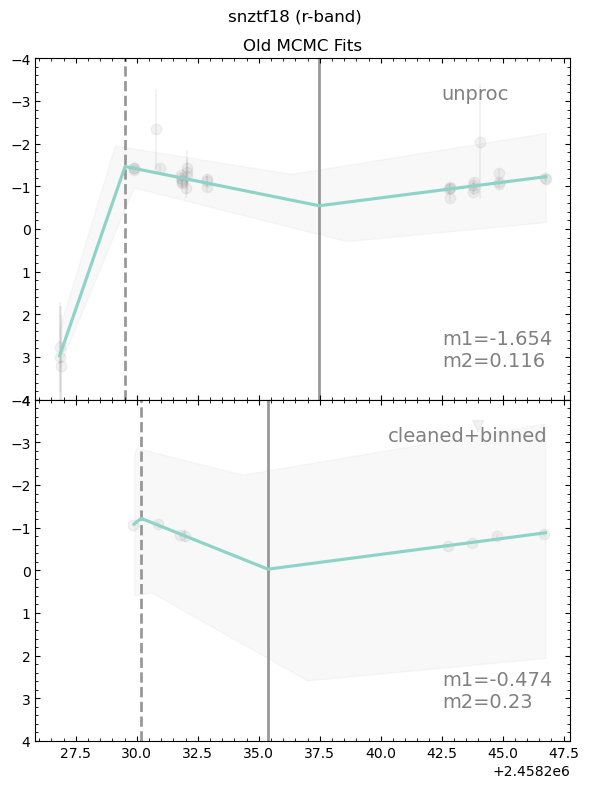

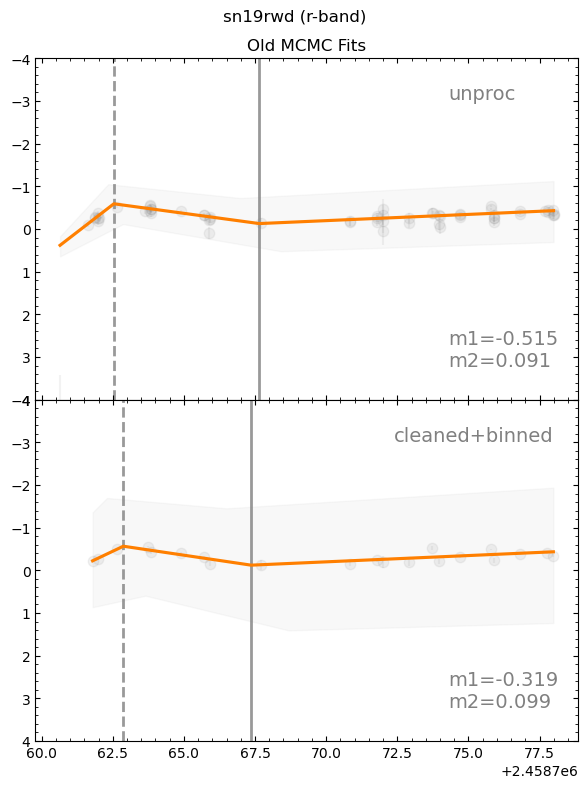

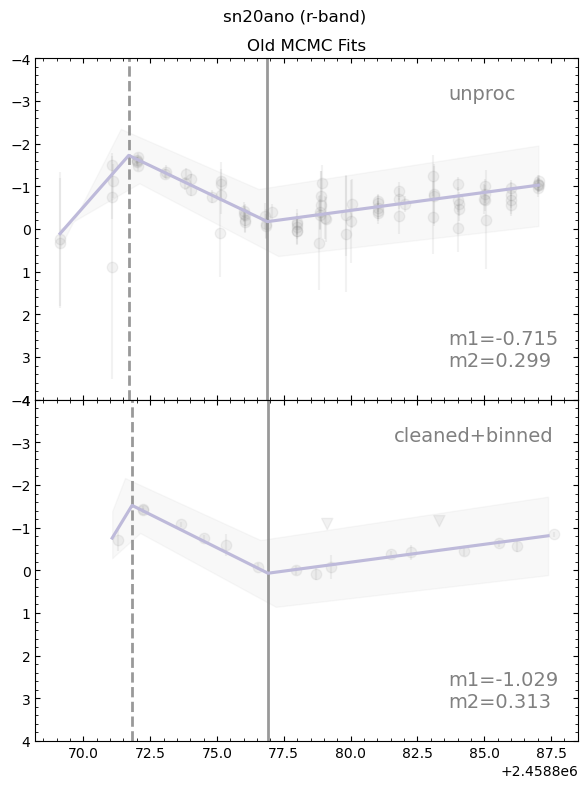

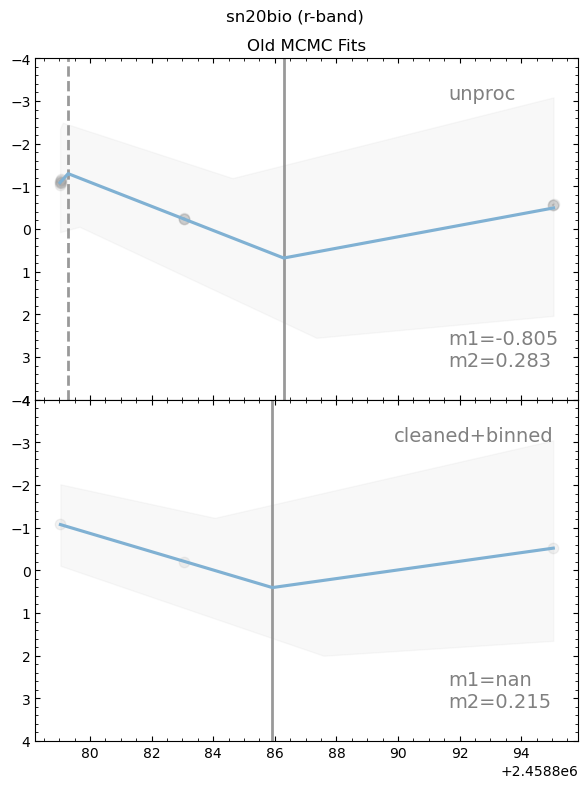

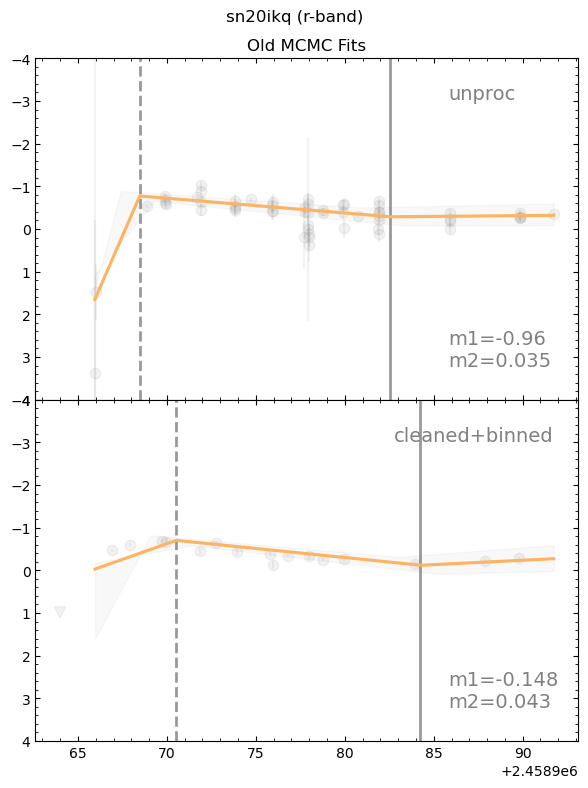

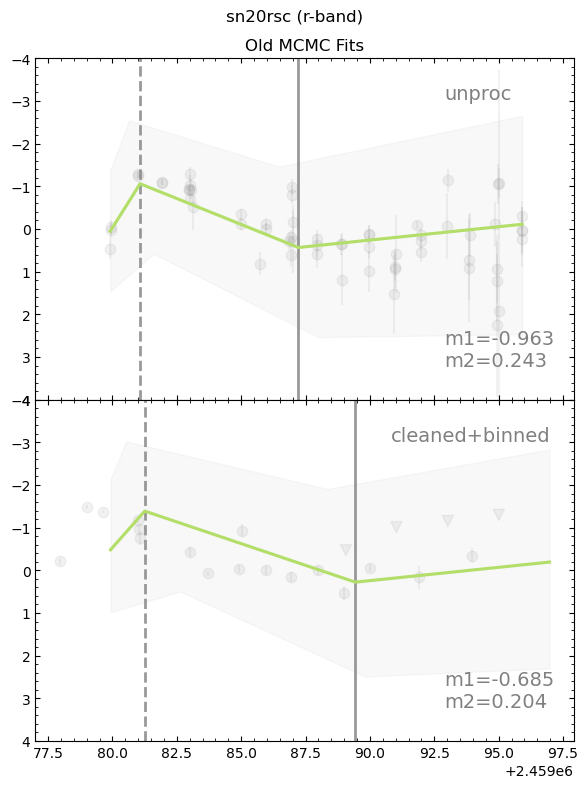

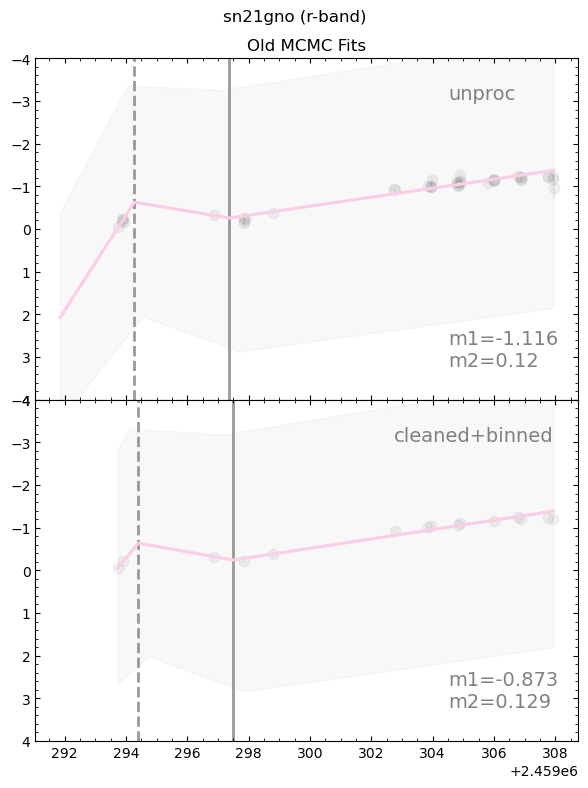

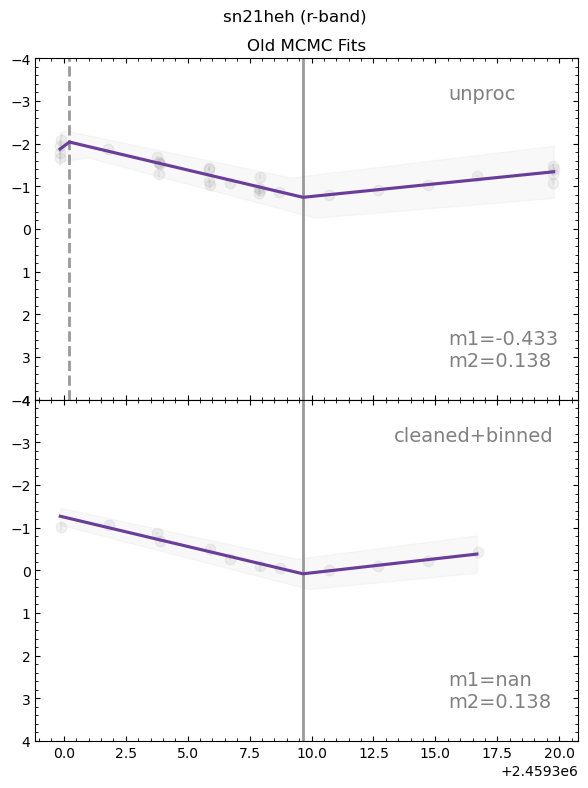

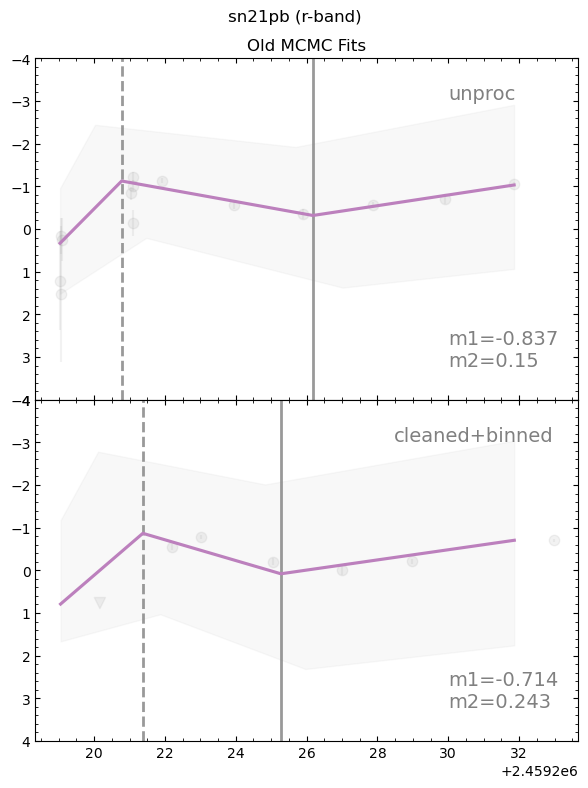

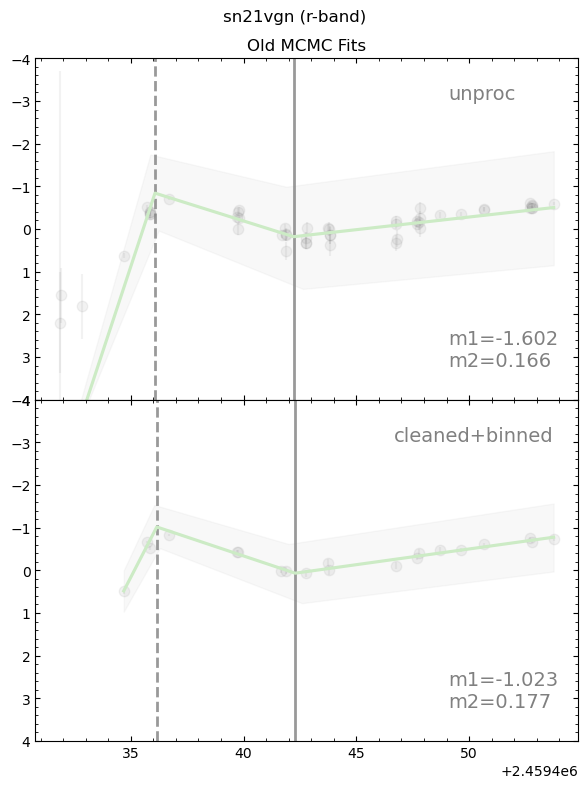

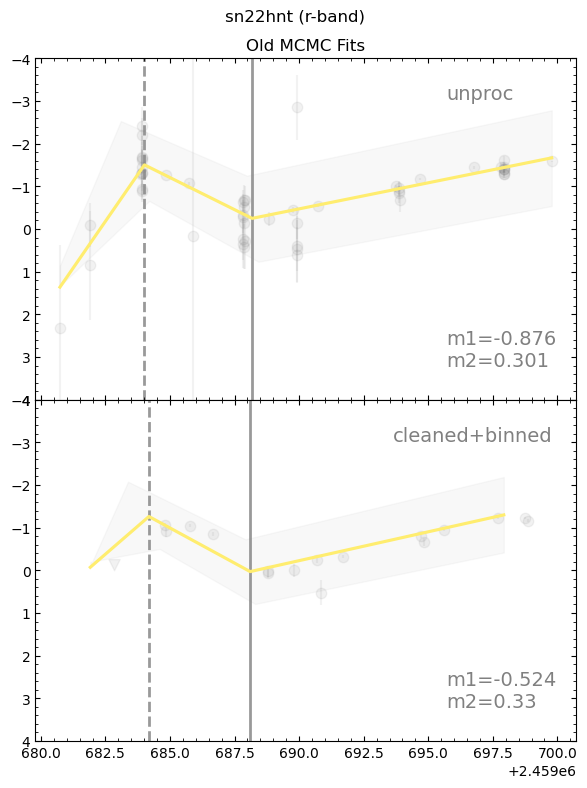

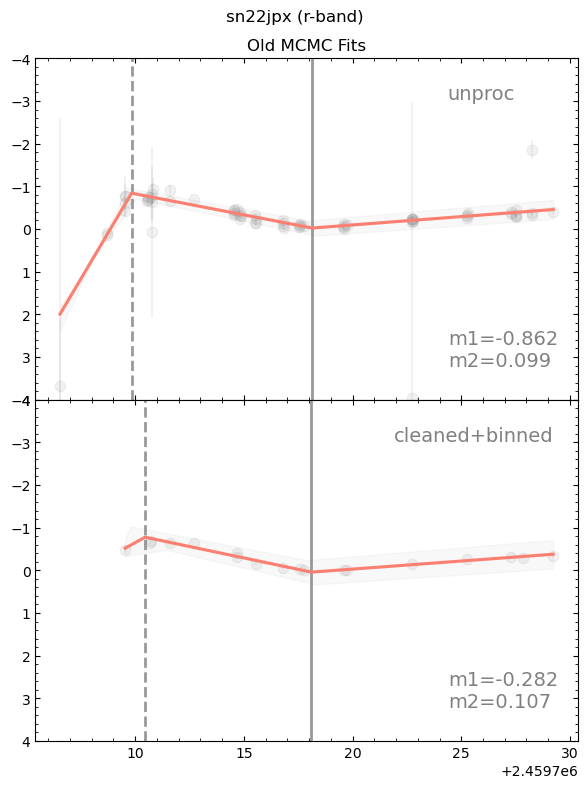

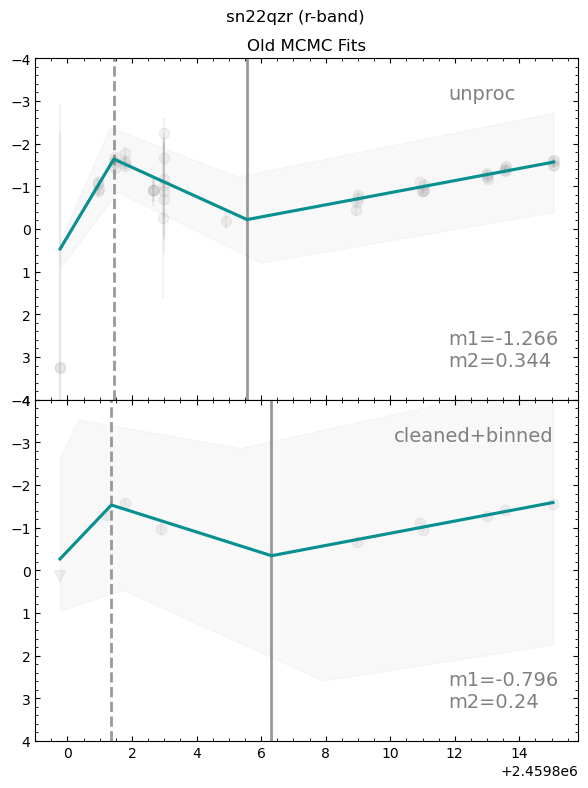

In [174]:
for i,df in enumerate(df_sub_ls):
    make_r_band_comparison(df, df_sub_ls_n[i], df_str_list[i], all_fits_r[i], all_fits_r_n[i], old_mjd_at_a2[i], new_mjd_at_a2[i], colors[i])

In [25]:
def insert_col_comp(df, col_names):
    every2 = [2,4,6,8,10,12,14]
    for i,v in enumerate(every2):
        df.insert(v,col_names[i]+'_new',bestfit_df_new[col_names[i]])
    return

comp_df_g = bestfit_df[['SN_ID','m1_g','m2_g','m3_g','b2_g','a1_g','a2_g','log_f_g']]
insert_col_comp(comp_df_g, ['m1_g','m2_g','m3_g','b2_g','a1_g','a2_g','log_f_g'])

comp_df_r = bestfit_df[['SN_ID','m1_r','m2_r','m3_r','b2_r','a1_r','a2_r','log_f_r']]
insert_col_comp(comp_df_r, ['m1_r','m2_r','m3_r','b2_r','a1_r','a2_r','log_f_r'])

In [26]:
comp_df_g

,SN_ID,m1_g,m1_g_new,m2_g,m2_g_new,m3_g,m3_g_new,b2_g,b2_g_new,a1_g,a1_g_new,a2_g,a2_g_new,log_f_g,log_f_g_new
0,snztf18,-1.453288,-0.441088,0.268554,0.339993,-0.052926,-0.141367,-3.864192,-4.072793,6.714141,7.646995,13.107969,14.073731,-3.746322,0.044069
1,sn19rwd,-0.979590,-0.730247,0.142178,0.137662,-0.049146,-0.052702,-1.921088,-1.862211,8.261812,8.372645,14.163972,14.235884,-2.701529,-2.821739
2,sn20ano,-0.606980,NaN,0.382998,0.385992,-0.088906,-0.110979,-5.203419,-5.028698,9.180605,NaN,14.371975,14.640632,-0.533924,-1.537835
3,sn20bio,-0.679592,-0.999993,0.187333,0.250002,-0.183369,-0.125014,-2.579680,-2.749999,9.410125,7.025532,14.717309,13.512784,1.364686,-1.999992
4,sn20ikq,-1.107506,-0.835783,0.107934,0.106653,-0.003755,-0.003670,-1.651887,-1.349933,2.241731,0.497618,14.641405,12.767812,-1.418653,-1.587851
5,sn20rsc,-1.542456,-1.270084,0.364869,0.372455,-0.036975,-0.116215,-5.069791,-4.467845,10.071302,8.112777,17.606733,14.829597,-1.621135,-1.038237
6,sn21gno,-1.589472,-0.844909,0.151964,0.161112,-0.089391,-0.094699,-2.115394,-2.240817,9.798067,9.387621,13.929084,13.996058,-1.423370,-1.304933
7,sn21heh,-1.018082,NaN,0.165181,0.209026,-0.073015,-0.058219,-2.609369,-2.181023,2.694032,NaN,14.985388,13.782958,-1.329173,-1.665501
8,sn21pb,NaN,NaN,0.231304,0.344176,-0.117904,-0.096742,-3.303867,-4.582536,NaN,NaN,13.760906,14.087840,-1.540608,-1.609341
9,sn21vgn,-0.857860,-1.021266,0.206177,0.187590,-0.064994,-0.065924,-2.372771,-2.345575,7.236515,7.061713,13.527217,14.015841,-1.622646,-2.613281


In [27]:
comp_df_r

,SN_ID,m1_r,m1_r_new,m2_r,m2_r_new,m3_r,m3_r_new,b2_r,b2_r_new,a1_r,a1_r_new,a2_r,a2_r_new,log_f_r,log_f_r_new
0,snztf18,-1.653940,-0.473561,0.115683,0.229834,-0.073302,-0.074937,-2.350598,-3.116938,7.663041,8.260315,15.613060,13.448832,-3.564006,-3.145814
1,sn19rwd,-0.514944,-0.318845,0.091144,0.099282,-0.029224,-0.029500,-1.386172,-1.464648,8.728792,9.058542,13.820153,13.540573,-1.902896,-1.339863
2,sn20ano,-0.715000,-1.029100,0.299137,0.312861,-0.084340,-0.083712,-4.335608,-4.358138,8.722938,9.065367,13.916714,14.149096,-3.500523,-3.356272
3,sn20bio,-0.805282,NaN,0.282817,0.214746,-0.133987,-0.101345,-3.897599,-2.991381,9.193014,NaN,16.188675,15.815197,-3.466265,-1.964035
4,sn20ikq,-0.960401,-0.148042,0.034754,0.042614,-0.003679,-0.020661,-0.828949,-0.772817,1.582649,1.651142,15.622305,15.384609,-1.472611,-2.734686
5,sn20rsc,-0.962749,-0.685342,0.242947,0.203831,-0.062612,-0.062373,-3.515344,-3.083430,10.101722,8.313001,16.254400,16.489876,0.209470,-0.131960
6,sn21gno,-1.115765,-0.873202,0.119778,0.128828,-0.105575,-0.109661,-1.871648,-1.992278,10.381562,10.514704,13.481051,13.595428,-2.602094,-2.445209
7,sn21heh,-0.433238,NaN,0.137601,0.137836,-0.059142,-0.065863,-2.657557,-1.840552,4.501014,NaN,13.922081,13.950519,-2.373261,-1.849520
8,sn21pb,-0.837429,-0.713595,0.150080,0.243400,-0.125843,-0.119189,-2.440361,-3.416329,8.766434,10.474214,14.156986,14.370467,-1.762168,-1.991667
9,sn21vgn,-1.602391,-1.023433,0.166318,0.176880,-0.059288,-0.073591,-2.048997,-2.313758,7.264507,7.334942,13.407664,13.464792,-0.335258,-2.118438


In [28]:
# MCMC FIT STATS
# best fit goes in order of: m1,m2,m3,b2,a1,a2,logf
def comp_stats(values,val=''):
    minv = np.nanmin(values)
    p25 = np.percentile(values, 25)
    p50 = np.percentile(values, 50)
    mean = np.nanmean(values)
    p75 = np.percentile(values, 75)
    maxv = np.nanmax(values)
    std = np.nanstd(values)
    # print('\033[1m'+val+': min,  25%,  med,  mean,  75%,  max,  std \033[0m \n', 
    #       round(minv,3),round(p25,3),round(p50,3),round(mean,3),round(p75,3),round(maxv,3,),round(std,3))#,'\n')
    return np.array([minv,p25,p50,mean,p75,maxv,std])

#computing the stats
stats_g, stats_r, stats_other = [],[],[]
for i in range(len(bestfit_df.columns[1:])):
    col = bestfit_df.columns[1:][i]
    if col[-2:] == '_g':
        g = comp_stats(bestfit_df[col],val=col)
        stats_g.append(g)
    elif col[-2:] == '_r':
        r = comp_stats(bestfit_df[col],val=col)
        stats_r.append(r)
    else: 
        o = comp_stats(bestfit_df[col],val=col)
        stats_other.append(o)
    
#saving to df 
stats_col = ['min','p25','med','mean','p75','max','std']
stats_df = pd.DataFrame(columns=stats_col, data=stats_g)
stats_df_r = pd.DataFrame(columns=stats_col, data=stats_r)
stats_df_other = pd.DataFrame(columns=stats_col, data=stats_other)
stats_df = pd.concat([stats_df,stats_df_r],ignore_index=True)
stats_df= pd.concat([stats_df,stats_df_other],ignore_index=True)
stats_df.insert(0, 'param', ['m1', 'm2', 'm3', 'b2', 'a1', 'a2', 'log_f']*2 + list(bestfit_df.columns[15:]))
stats_df['filter'] = ['g']*len(stats_g) + ['r']*len(stats_r) + ['both']*len(bestfit_df.columns[15:]) #note: t_half-r & a1_abs_mag-r mislabeled by this line as 'both'
# stats_df.to_csv(SAVE_DIR+'/mcmc_bestfit_stats.csv')

stats_df[['param','min','mean','max','std','filter']]
# stats_df

,param,min,mean,max,std,filter
0,m1,-1.589472,-1.092759,-0.606980,0.343090,g
1,m2,0.107934,0.228403,0.382998,0.086594,g
2,m3,-0.183369,-0.083888,-0.003755,0.050823,g
3,b2,-5.203419,-3.166192,-1.651887,1.193934,g
4,a1,2.241731,7.289814,10.071302,2.788512,g
5,a2,12.558127,14.339693,17.606733,1.166895,g
6,log_f,-3.746322,-1.440054,1.364686,1.242304,g
7,m1,-1.653940,-0.969596,-0.433238,0.351033,r
8,m2,0.034754,0.183373,0.343726,0.094605,r
9,m3,-0.141956,-0.080030,-0.003679,0.041690,r


In [29]:
# MCMC FIT STATS
# best fit goes in order of: m1,m2,m3,b2,a1,a2,logf
def comp_stats(values,val=''):
    minv = np.nanmin(values)
    p25 = np.percentile(values, 25)
    p50 = np.percentile(values, 50)
    mean = np.nanmean(values)
    p75 = np.percentile(values, 75)
    maxv = np.nanmax(values)
    std = np.nanstd(values)
    # print('\033[1m'+val+': min,  25%,  med,  mean,  75%,  max,  std \033[0m \n', 
    #       round(minv,3),round(p25,3),round(p50,3),round(mean,3),round(p75,3),round(maxv,3,),round(std,3))#,'\n')
    return np.array([minv,p25,p50,mean,p75,maxv,std])

#computing the stats
stats_g_n, stats_r_n, stats_other_n = [],[],[]
for i in range(len(bestfit_df_new.columns[1:])):
    col = bestfit_df_new.columns[1:][i]
    if col[-2:] == '_g':
        g = comp_stats(bestfit_df_new[col],val=col)
        stats_g_n.append(g)
    elif col[-2:] == '_r':
        r = comp_stats(bestfit_df_new[col],val=col)
        stats_r_n.append(r)
    else: 
        o = comp_stats(bestfit_df_new[col],val=col)
        stats_other_n.append(o)
    
#saving to df 
stats_col = ['min','p25','med','mean','p75','max','std']
stats_df_n = pd.DataFrame(columns=stats_col, data=stats_g_n)
stats_df_r_n = pd.DataFrame(columns=stats_col, data=stats_r_n)
stats_df_other_n = pd.DataFrame(columns=stats_col, data=stats_other_n)
stats_df_n = pd.concat([stats_df_n,stats_df_r_n],ignore_index=True)
stats_df_n = pd.concat([stats_df_n,stats_df_other_n],ignore_index=True)
stats_df_n.insert(0, 'param', ['m1', 'm2', 'm3', 'b2', 'a1', 'a2', 'log_f']*2 + list(bestfit_df_new.columns[15:]))
stats_df_n['filter'] = ['g']*len(stats_g_n) + ['r']*len(stats_r_n) + ['both']*len(bestfit_df_new.columns[15:]) #note: t_half-r & a1_abs_mag-r mislabeled by this line as 'both'
# stats_df.to_csv(SAVE_DIR+'/mcmc_bestfit_stats.csv')

stats_df_n[['param','min','mean','max','std','filter']]
# stats_df

,param,min,mean,max,std,filter
0,m1,-1.270084,-0.877625,-0.441088,0.240457,g
1,m2,0.106653,0.257700,0.385992,0.096585,g
2,m3,-0.157826,-0.091931,-0.003670,0.046930,g
3,b2,-5.028698,-3.266844,-1.349933,1.313638,g
4,a1,0.497618,6.872129,9.387621,2.710106,g
5,a2,12.767812,14.042948,15.103737,0.618000,g
6,log_f,-3.327709,-1.632972,0.044069,0.901455,g
7,m1,-1.029100,-0.624269,-0.148042,0.285455,r
8,m2,0.042614,0.189779,0.329860,0.081245,r
9,m3,-0.142996,-0.081296,-0.020661,0.037541,r


In [30]:
################################################
#    detailed comparison w/ robust fits 
################################################

In [31]:
# best objects in old and new are:
# sn19rwd_g, index = 1
# sn20ano_r, index = 2
# sn21gno_r, index = 6
# sn21heh_g, index = 7

sn19rwd_g_old = sn19rwd.loc[(sn19rwd['filter']=='ZTF_g') | (sn19rwd['filter']=='c')]
sn19rwd_g_new = sn19rwd_n.loc[(sn19rwd_n['filter']=='ZTF_g') | (sn19rwd_n['filter']=='c')]

sn20ano_r_old = sn20ano.loc[(sn20ano['filter']=='ZTF_r') | (sn20ano['filter']=='o')]
sn20ano_r_new = sn20ano_n.loc[(sn20ano_n['filter']=='ZTF_r') | (sn20ano_n['filter']=='o')]

sn21gno_r_old = sn21gno.loc[(sn21gno['filter']=='ZTF_r') | (sn21gno['filter']=='o')]
sn21gno_r_new = sn21gno_n.loc[(sn21gno_n['filter']=='ZTF_r') | (sn21gno_n['filter']=='o')]

sn21heh_g_old = sn21heh.loc[(sn21heh['filter']=='ZTF_g') | (sn21heh['filter']=='c')]
sn21heh_g_new = sn21heh_n.loc[(sn21heh_n['filter']=='ZTF_g') | (sn21heh_n['filter']=='c')]

# robust_old_df = [sn19rwd_g_old, sn20ano_r_old, sn21gno_r_old, sn21heh_g_old]
# robust_new_df = [sn19rwd_g_new, sn20ano_r_new, sn21gno_r_new, sn21heh_g_new]
robust_df_str = ['sn19rw', 'sn20an', 'sn21gn', 'sn21heh']

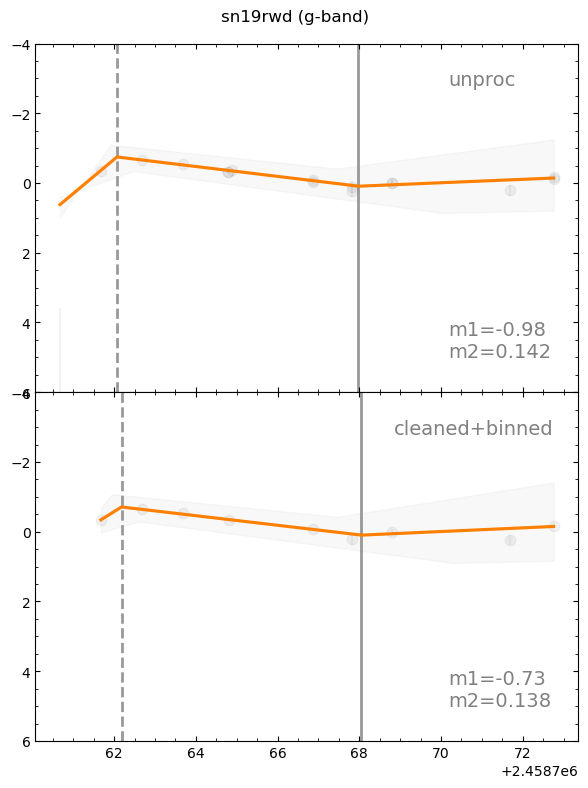

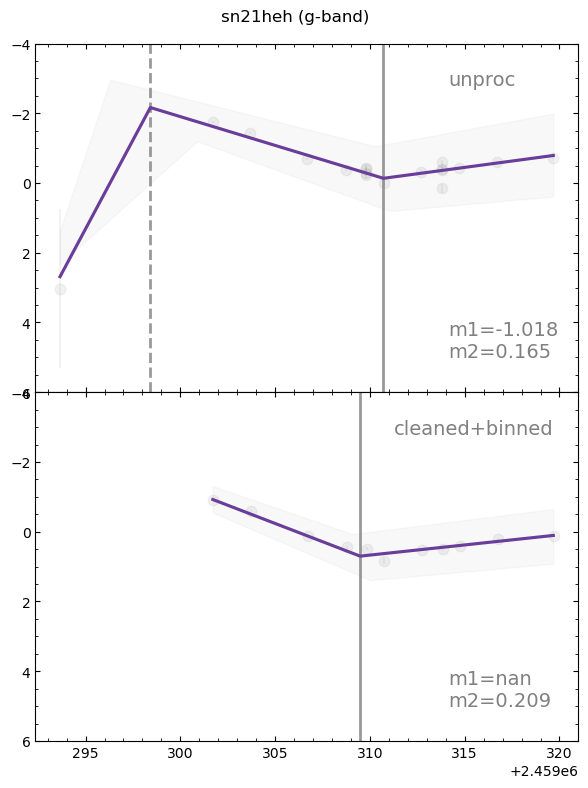

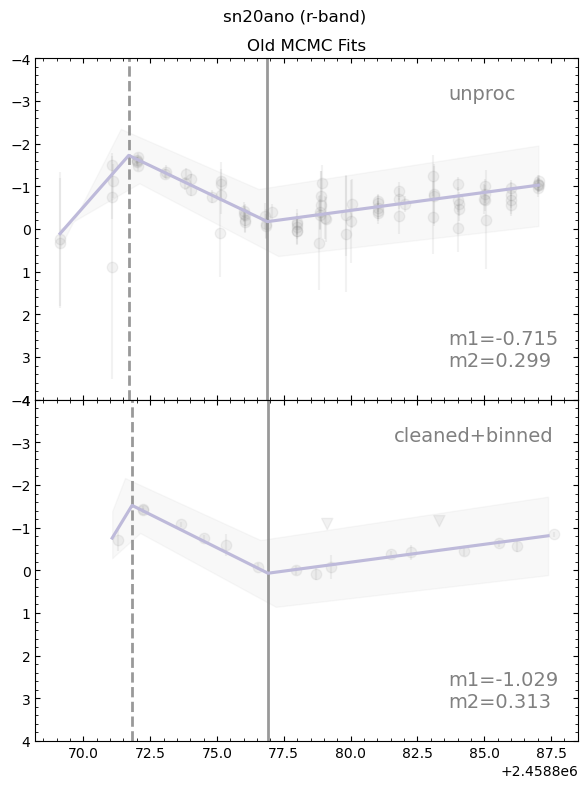

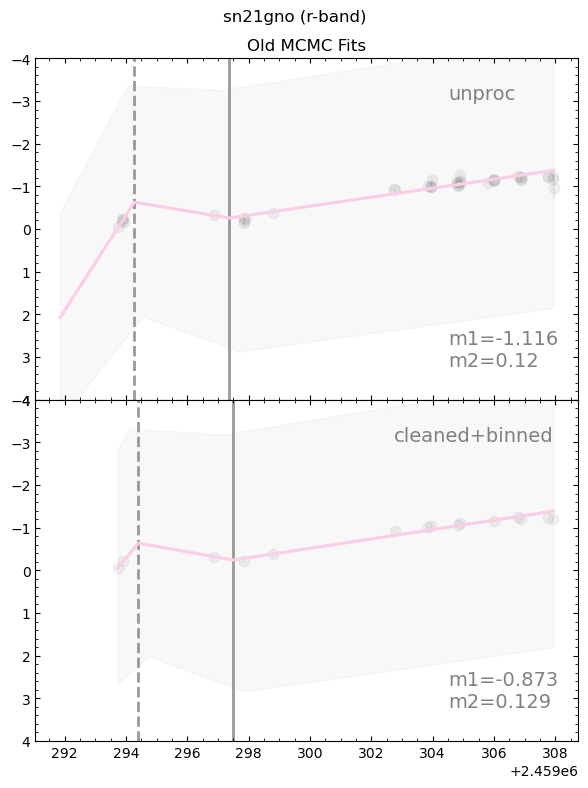

In [83]:
make_g_band_comparison(sn19rwd_g_old, sn19rwd_g_new, 'sn19rwd', all_fits_g[1], all_fits_g_n[1], old_mjd_at_a2[1], new_mjd_at_a2[1], colors[1])
make_g_band_comparison(sn21heh_g_old, sn21heh_g_new, 'sn21heh', all_fits_g[7], all_fits_g_n[7], old_mjd_at_a2[7], new_mjd_at_a2[7], colors[7])

make_r_band_comparison(sn20ano_r_old, sn20ano_r_new, 'sn20ano', all_fits_r[2], all_fits_r_n[2], old_mjd_at_a2[2], new_mjd_at_a2[2], colors[2])
make_r_band_comparison(sn21gno_r_old, sn21gno_r_new, 'sn21gno', all_fits_r[6], all_fits_r_n[6], old_mjd_at_a2[6], new_mjd_at_a2[6], colors[6])


In [57]:
# bestfit_df.iloc[[1,2,6,7]]

In [58]:
# bestfit_df_new.iloc[[1,2,6,7]]

In [75]:
def print_fit_comps(val,i):
    print('PARAM:',val)
    print('old fits:\n16th, 50th, 84th')
    print(round(bestfit_df[val].iloc[i]-low_err_df_old[val].iloc[i],3),
          round(bestfit_df[val].iloc[i],3),
          round(bestfit_df[val].iloc[i]+upp_err_df_old[val].iloc[i],3),
          )
    print('new fits:\n16th, 50th, 84th')
    print(round(bestfit_df_new[val].iloc[i]-low_err_df_new[val].iloc[i],3),
          round(bestfit_df_new[val].iloc[i],3),
          round(bestfit_df_new[val].iloc[i]+upp_err_df_new[val].iloc[i],3),
          '\n')

In [76]:
#SN19RWD
print('ON SN19RWD')
print_fit_comps('m1_g',1)
print_fit_comps('m2_g',1)
print_fit_comps('m3_g',1)
print_fit_comps('b2_g',1)
print_fit_comps('a1_g',1)
print_fit_comps('a2_g',1)
print_fit_comps('log_f_g',1)

ON SN19RWD
PARAM: m1_g
old fits:
16th, 50th, 84th
-1.668 -0.98 -0.413
new fits:
16th, 50th, 84th
-1.467 -0.73 -0.336 

PARAM: m2_g
old fits:
16th, 50th, 84th
0.124 0.142 0.159
new fits:
16th, 50th, 84th
0.119 0.138 0.155 

PARAM: m3_g
old fits:
16th, 50th, 84th
-0.157 -0.049 -0.025
new fits:
16th, 50th, 84th
-0.186 -0.053 -0.026 

PARAM: b2_g
old fits:
16th, 50th, 84th
-2.103 -1.921 -1.717
new fits:
16th, 50th, 84th
-2.052 -1.862 -1.659 

PARAM: a1_g
old fits:
16th, 50th, 84th
8.109 8.262 8.664
new fits:
16th, 50th, 84th
8.139 8.373 8.802 

PARAM: a2_g
old fits:
16th, 50th, 84th
13.64 14.164 16.225
new fits:
16th, 50th, 84th
13.644 14.236 16.484 

PARAM: log_f_g
old fits:
16th, 50th, 84th
-3.526 -2.702 -1.934
new fits:
16th, 50th, 84th
-3.62 -2.822 -1.789 



In [77]:
#SN21HEH
print('ON SN21HEH')
print_fit_comps('m1_g',7)
print_fit_comps('m2_g',7)
print_fit_comps('m3_g',7)
print_fit_comps('b2_g',7)
print_fit_comps('a1_g',7)
print_fit_comps('a2_g',7)
print_fit_comps('log_f_g',7)

ON SN21HEH
PARAM: m1_g
old fits:
16th, 50th, 84th
-1.632 -1.018 -0.487
new fits:
16th, 50th, 84th
nan nan nan 

PARAM: m2_g
old fits:
16th, 50th, 84th
0.137 0.165 0.197
new fits:
16th, 50th, 84th
0.187 0.209 0.233 

PARAM: m3_g
old fits:
16th, 50th, 84th
-0.1 -0.073 -0.048
new fits:
16th, 50th, 84th
-0.068 -0.058 -0.049 

PARAM: b2_g
old fits:
16th, 50th, 84th
-3.042 -2.609 -2.215
new fits:
16th, 50th, 84th
-2.434 -2.181 -1.95 

PARAM: a1_g
old fits:
16th, 50th, 84th
0.578 2.694 5.169
new fits:
16th, 50th, 84th
nan nan nan 

PARAM: a2_g
old fits:
16th, 50th, 84th
14.565 14.985 15.33
new fits:
16th, 50th, 84th
13.391 13.783 14.331 

PARAM: log_f_g
old fits:
16th, 50th, 84th
-1.838 -1.329 -0.913
new fits:
16th, 50th, 84th
-2.001 -1.666 -1.32 



In [78]:
#SN20ANO
print('ON SN20ANO')
print_fit_comps('m1_r',2)
print_fit_comps('m2_r',2)
print_fit_comps('m3_r',2)
print_fit_comps('b2_r',2)
print_fit_comps('a1_r',2)
print_fit_comps('a2_r',2)
print_fit_comps('log_f_r',2)

ON SN20ANO
PARAM: m1_r
old fits:
16th, 50th, 84th
-1.225 -0.715 -0.363
new fits:
16th, 50th, 84th
-1.623 -1.029 -0.563 

PARAM: m2_r
old fits:
16th, 50th, 84th
0.273 0.299 0.328
new fits:
16th, 50th, 84th
0.287 0.313 0.341 

PARAM: m3_r
old fits:
16th, 50th, 84th
-0.097 -0.084 -0.072
new fits:
16th, 50th, 84th
-0.095 -0.084 -0.073 

PARAM: b2_r
old fits:
16th, 50th, 84th
-4.65 -4.336 -4.063
new fits:
16th, 50th, 84th
-4.691 -4.358 -4.069 

PARAM: a1_r
old fits:
16th, 50th, 84th
8.428 8.723 9.122
new fits:
16th, 50th, 84th
8.801 9.065 9.367 

PARAM: a2_r
old fits:
16th, 50th, 84th
13.585 13.917 14.32
new fits:
16th, 50th, 84th
13.87 14.149 14.444 

PARAM: log_f_r
old fits:
16th, 50th, 84th
-3.851 -3.501 -3.007
new fits:
16th, 50th, 84th
-3.808 -3.356 -2.711 



In [79]:
#SN21GNO
print('ON SN21GNO')
print_fit_comps('m1_r',6)
print_fit_comps('m2_r',6)
print_fit_comps('m3_r',6)
print_fit_comps('b2_r',6)
print_fit_comps('a1_r',6)
print_fit_comps('a2_r',6)
print_fit_comps('log_f_r',6)

ON SN21GNO
PARAM: m1_r
old fits:
16th, 50th, 84th
-1.348 -1.116 -0.896
new fits:
16th, 50th, 84th
-1.151 -0.873 -0.601 

PARAM: m2_r
old fits:
16th, 50th, 84th
0.031 0.12 0.259
new fits:
16th, 50th, 84th
0.04 0.129 0.263 

PARAM: m3_r
old fits:
16th, 50th, 84th
-0.111 -0.106 -0.1
new fits:
16th, 50th, 84th
-0.118 -0.11 -0.102 

PARAM: b2_r
old fits:
16th, 50th, 84th
-3.679 -1.872 -0.708
new fits:
16th, 50th, 84th
-3.732 -1.992 -0.832 

PARAM: a1_r
old fits:
16th, 50th, 84th
10.158 10.382 10.66
new fits:
16th, 50th, 84th
10.237 10.515 10.87 

PARAM: a2_r
old fits:
16th, 50th, 84th
13.229 13.481 13.829
new fits:
16th, 50th, 84th
13.311 13.595 13.966 

PARAM: log_f_r
old fits:
16th, 50th, 84th
-2.788 -2.602 -2.411
new fits:
16th, 50th, 84th
-2.711 -2.445 -2.15 



In [80]:
################################################
#    comparing 20ano MCMC fits for clean+avg 
################################################

In [48]:
# df_str = 'sn20ano'
# plot_name = '20ano'

# #old version
# sn20ano = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn20ano.csv')
# #r1_g, r1_r = True, True
# print(sn20ano.columns)

# #new version
# sn20ano_cl = pd.read_csv('./cleaning/outputs/sn20ano_cleaned_binned_cut.csv')
# sn20ano_cl['JD'] = sn20ano_cl['mjd']+2400000.5
# sn20ano_cl['mag_err_all'] = sn20ano_cl['err']

# a2_ind = 40

# norm_LC_a2(sn20ano_cl, a2_ind)

# sn20ano_cl,a2 = subselect(sn20ano_cl)
# #r1_g, r1_r = False, True
# sn20ano_cl.columns

Index(['JD', 'filter', 'mag', 'ztf_mag_lower', 'ztf_mag_upper',
       'atlas_mag_err', 'data_origin', 'norm_t', 'norm_m', 'max_ztf_err',
       'mag_err_all'],
      dtype='object')
JD @ a2 =  2458877.7548206


25

In [30]:
# # if code crashes, reload the chains here to find bestfit
# # g_chains = []
# # r_chains = []
# # for i in range(len(df_str_list)):
# #     save_dir = './mcmc_fp_results/flatchains/'
# #     gf = save_dir+df_str_list[i]+'_g_flatchains.txt'
# #     rf = save_dir+df_str_list[i]+'_r_flatchains.txt'
# #     g_chains.append(gf)
# #     r_chains.append(rf)

# def bestfit_recovery(filename, sub_df, band='', r1_bool=True, sn_id_band='test_g', replot=False, save=False):
#     flat_samples = np.loadtxt(filename)
#     if r1_bool:
#         ndim = 7
#     if not r1_bool:
#         ndim = 5

#     mcmc_results = []
#     #retrieve the 16th/50th/84th percentile for each param and the lower/upper bounds on each
#     for i in range(ndim):
#         mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
#         q = np.diff(mcmc)
#         arr = [mcmc[1], q[0], q[1]]
#         mcmc_results.append(arr)

#     # making fit/autocorr/corner plots
#     if band == 'g':
#         g_df = sub_df[(sub_df['filter']=='ZTF_g') | (sub_df['filter']=='c')]
#         x,y,yerr = np.array(g_df['norm_t']),np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
#     if band == 'r':
#         r_df = sub_df[(sub_df['filter']=='ZTF_r') | (sub_df['filter']=='o')]
#         x,y,yerr = np.array(r_df['norm_t']),np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
#     if replot:
#         plot_mcmc_results(x, y, yerr, mcmc_results, flat_samples, r1=r1_bool, sn_band=sn_id_band, save=save)
#         do_gw_autocorr_and_plot(filename, sn_id_band, save=save)

#     return mcmc_results#,flat_samples

In [31]:
# sn20ano_old_fit_g = bestfit_recovery('./mcmc_fp_results/flatchains/sn20ano_g_flatchains.txt',
#                                      sn20ano, band='g', r1_bool=True, sn_id_band='sn20ano_g', replot=False)
# sn20ano_old_fit_r = bestfit_recovery('./mcmc_fp_results/flatchains/sn20ano_r_flatchains.txt',
#                                      sn20ano, band='r', r1_bool=True, sn_id_band='sn20ano_r', replot=False)

In [32]:
# sn20ano_new_fit_g = bestfit_recovery('./cleaning/outputs/sn20ano_g_flatchains.txt',
#                                      sn20ano, band='g', r1_bool=False, sn_id_band='sn20ano_g', replot=False)
# sn20ano_new_fit_r = bestfit_recovery('./cleaning/outputs/sn20ano_r_flatchains.txt',
#                                      sn20ano, band='r', r1_bool=True, sn_id_band='sn20ano_r', replot=False)

In [33]:
# ## CREATING DF FOR OLD MCMC

# #the next two loops separate out the indivudal param values and append to list to do stats on them
# best_fits_g,best_fits_r = [],[]
# low_err_g, upp_err_g =[],[]
# low_err_r, upp_err_r =[],[]

# # for i in range(len(all_fits_r)):
# #g band
# bestg = np.array(sn20ano_old_fit_g).T[0]  #bestfit (50% ptile) values
# lowg = np.array(sn20ano_old_fit_g).T[1]   #lower bound, 16% ptile
# highg =  np.array(sn20ano_old_fit_g).T[2] #upper bound, 84% ptile
# best_fits_g.append(bestg)
# low_err_g.append(lowg)
# upp_err_g.append(highg)

# #r band
# bestr = np.array(sn20ano_old_fit_r).T[0]  #bestfit (50% ptile) values
# lowr = np.array(sn20ano_old_fit_r).T[1]   #lower bound, 16% ptile
# highr =  np.array(sn20ano_old_fit_r).T[2] #upper bound, 84% ptile
# best_fits_r.append(bestr)
# low_err_r.append(lowr)
# upp_err_r.append(highr)

# # formatting and saving best fits values in g and r
# def format_arr(arr_in):
#     if len(arr_in) == 5:
#         arr = np.insert(arr_in, [0,3], np.nan)
#     else:
#         arr = arr_in
#     return arr

# best_fits_g_same_len = []
# for i,arr in enumerate(best_fits_g):
#     arr = format_arr(arr)
#     best_fits_g_same_len.append(arr)

# best_fits_r_same_len = []
# for i,arr in enumerate(best_fits_r):
#     arr = format_arr(arr)
#     best_fits_r_same_len.append(arr)

# low_err_g_same_len = []
# for i,arr in enumerate(low_err_g):
#     arr = format_arr(arr)
#     low_err_g_same_len.append(arr)

# low_err_r_same_len = []
# for i,arr in enumerate(low_err_r):
#     arr = format_arr(arr)
#     low_err_r_same_len.append(arr)

# upp_err_g_same_len = []
# for i,arr in enumerate(upp_err_g):
#     arr = format_arr(arr)
#     upp_err_g_same_len.append(arr)

# upp_err_r_same_len = []
# for i,arr in enumerate(upp_err_r):
#     arr = format_arr(arr)
#     upp_err_r_same_len.append(arr)

# #saving to df
# best_fits_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
# best_fits_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
# bestfit_df = pd.DataFrame(columns=best_fits_cols_g, data=best_fits_g_same_len)
# bestfit_r_df = pd.DataFrame(columns=best_fits_cols_r, data=best_fits_r_same_len)
# bestfit_df.insert(0,'SN_ID', 'sn20ano')
# bestfit_df_old = pd.concat([bestfit_df,bestfit_r_df], axis=1)

# #same sn, same lc, same filters, diff params
# bestfit_df_old['a2g-a1g'] = bestfit_df_old['a2_g'] - bestfit_df_old['a1_g']
# bestfit_df_old['a2r-a1r'] = bestfit_df_old['a2_r'] - bestfit_df_old['a1_r']
# #same sn, diff lc, diff filters, same params
# bestfit_df_old['a1g-a1r'] = bestfit_df_old['a1_g'] - bestfit_df_old['a1_r']
# bestfit_df_old['a2g-a2r'] = bestfit_df_old['a2_g'] - bestfit_df_old['a2_r']

# #finding the model mag at bestfit: a1/a2 for each band

# m_a2g_a1g_ls, m_a2r_a1r_ls, m_a1g_a1r_ls, m_a2g_a2r_ls = [],[],[],[]
# #gband
# g_df = sn20ano[(sn20ano['filter']=='ZTF_g') | (sn20ano['filter']=='c')]
# x_plt_g = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)
# sn_g = bestfit_df_old.loc[:,bestfit_df_old.columns.str[-2:]=='_g'].loc[i]
# sn_g = sn_g.loc[sn_g.notna()].to_numpy()
# a1_g, a2_g = bestfit_df_old['a1_g'].loc[i], bestfit_df_old['a2_g'].loc[i]
# a1crit_g = np.abs(x_plt_g - a1_g).argmin()
# a2crit_g = np.abs(x_plt_g - a2_g).argmin()

# mags_g = np.array([model(sn_g, v, r1=True) for v in x_plt_g])
# a1_gmag = mags_g[a1crit_g] 
# a2_gmag = mags_g[a2crit_g]

# #rband
# r_df = sn20ano[(sn20ano['filter']=='ZTF_r') | (sn20ano['filter']=='o')]
# x_plt_r = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)
# sn_r = bestfit_df_old.loc[:,bestfit_df_old.columns.str[-2:]=='_r'].loc[i]
# sn_r = sn_r.loc[sn_r.notna()].to_numpy()
# a1_r, a2_r = bestfit_df_old['a1_r'].loc[i], bestfit_df_old['a2_r'].loc[i]
# a1crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a1_r).argmin()]
# a2crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a2_r).argmin()]

# mags_r = np.array([model(sn_r, v, r1=True) for v in x_plt_r])
# a1_rmag = mags_r[a1crit_r]
# a2_rmag = mags_r[a2crit_r]

# #calcing quants
# m_a2g_a1g = a2_gmag - a1_gmag
# m_a2r_a1r = a2_rmag - a1_rmag
# m_a1g_a1r = a1_gmag - a1_rmag
# m_a2g_a2r = a2_gmag - a2_rmag

# #appending
# m_a2g_a1g_ls.append(m_a2g_a1g)
# m_a2r_a1r_ls.append(m_a2r_a1r[0])
# m_a1g_a1r_ls.append(m_a1g_a1r[0])
# m_a2g_a2r_ls.append(m_a2g_a2r[0])

# bestfit_df_old['mag_a2g-a1g'] = m_a2g_a1g_ls
# bestfit_df_old['mag_a2r-a1r'] = m_a2r_a1r_ls
# bestfit_df_old['mag_a1g-a1r'] = m_a1g_a1r_ls
# bestfit_df_old['mag_a2g-a2r'] = m_a2g_a2r_ls

# bestfit_df_old

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,...,a2_r,log_f_r,a2g-a1g,a2r-a1r,a1g-a1r,a2g-a2r,mag_a2g-a1g,mag_a2r-a1r,mag_a1g-a1r,mag_a2g-a2r
0,sn20ano,-0.60698,0.382998,-0.088906,-5.203419,9.180605,14.371975,-0.533924,-0.715,0.299137,...,13.916714,-3.500523,5.19137,5.193776,0.457667,0.455261,1.987588,1.552494,0.038507,0.473601


In [34]:
# #saving lower bound errs to df
# low_err_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
# low_err_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
# low_err_df = pd.DataFrame(columns=low_err_cols_g, data=low_err_g_same_len)
# low_err_r_df = pd.DataFrame(columns=low_err_cols_r, data=low_err_r_same_len)
# low_err_df.insert(0,'SN_ID', 'sn20ano')
# low_err_df_old = pd.concat([low_err_df,low_err_r_df], axis=1)
# print(low_err_df_old,'\n')

# #saving upper bound errs to df
# upp_err_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
# upp_err_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
# upp_err_df = pd.DataFrame(columns=upp_err_cols_g, data=upp_err_g_same_len)
# upp_err_r_df = pd.DataFrame(columns=upp_err_cols_r, data=upp_err_r_same_len)
# upp_err_df.insert(0,'SN_ID', 'sn20ano')
# upp_err_df_old = pd.concat([upp_err_df,upp_err_r_df], axis=1)
# print(upp_err_df_old)

     SN_ID      m1_g      m2_g      m3_g      b2_g      a1_g      a2_g  \
0  sn20ano  0.823853  0.024092  0.020993  0.177081  0.162335  0.382983   

    log_f_g     m1_r      m2_r      m3_r     b2_r      a1_r      a2_r  \
0  0.179951  0.50956  0.025892  0.012986  0.31414  0.294624  0.331321   

    log_f_r  
0  0.350567   

     SN_ID      m1_g      m2_g      m3_g      b2_g      a1_g      a2_g  \
0  sn20ano  0.463959  0.012142  0.019056  0.299771  0.320457  0.369522   

   log_f_g      m1_r      m2_r      m3_r      b2_r      a1_r      a2_r  \
0  0.20038  0.352134  0.028884  0.012092  0.272338  0.399111  0.403346   

    log_f_r  
0  0.493316  


In [35]:
# ## CREATING DF FOR NEW MCMC

# #the next two loops separate out the indivudal param values and append to list to do stats on them
# best_fits_g,best_fits_r = [],[]
# low_err_g, upp_err_g =[],[]
# low_err_r, upp_err_r =[],[]

# # for i in range(len(all_fits_r)):
# #g band
# bestg = np.array(sn20ano_new_fit_g).T[0]  #bestfit (50% ptile) values
# lowg = np.array(sn20ano_new_fit_g).T[1]   #lower bound, 16% ptile
# highg =  np.array(sn20ano_new_fit_g).T[2] #upper bound, 84% ptile
# best_fits_g.append(bestg)
# low_err_g.append(lowg)
# upp_err_g.append(highg)

# #r band
# bestr = np.array(sn20ano_new_fit_r).T[0]  #bestfit (50% ptile) values
# lowr = np.array(sn20ano_new_fit_r).T[1]   #lower bound, 16% ptile
# highr =  np.array(sn20ano_new_fit_r).T[2] #upper bound, 84% ptile
# best_fits_r.append(bestr)
# low_err_r.append(lowr)
# upp_err_r.append(highr)

# best_fits_g_same_len = []
# for i,arr in enumerate(best_fits_g):
#     arr = format_arr(arr)
#     best_fits_g_same_len.append(arr)

# best_fits_r_same_len = []
# for i,arr in enumerate(best_fits_r):
#     arr = format_arr(arr)
#     best_fits_r_same_len.append(arr)

# low_err_g_same_len = []
# for i,arr in enumerate(low_err_g):
#     arr = format_arr(arr)
#     low_err_g_same_len.append(arr)

# low_err_r_same_len = []
# for i,arr in enumerate(low_err_r):
#     arr = format_arr(arr)
#     low_err_r_same_len.append(arr)

# upp_err_g_same_len = []
# for i,arr in enumerate(upp_err_g):
#     arr = format_arr(arr)
#     upp_err_g_same_len.append(arr)

# upp_err_r_same_len = []
# for i,arr in enumerate(upp_err_r):
#     arr = format_arr(arr)
#     upp_err_r_same_len.append(arr)


# #saving to df
# best_fits_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
# best_fits_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
# bestfit_df = pd.DataFrame(columns=best_fits_cols_g, data=best_fits_g_same_len)
# bestfit_r_df = pd.DataFrame(columns=best_fits_cols_r, data=best_fits_r_same_len)
# bestfit_df.insert(0,'SN_ID', 'sn20ano')
# bestfit_df_new = pd.concat([bestfit_df,bestfit_r_df], axis=1)

# #same sn, same lc, same filters, diff params
# bestfit_df_new['a2g-a1g'] = bestfit_df_new['a2_g'] - bestfit_df_new['a1_g']
# bestfit_df_new['a2r-a1r'] = bestfit_df_new['a2_r'] - bestfit_df_new['a1_r']
# #same sn, diff lc, diff filters, same params
# bestfit_df_new['a1g-a1r'] = bestfit_df_new['a1_g'] - bestfit_df_new['a1_r']
# bestfit_df_new['a2g-a2r'] = bestfit_df_new['a2_g'] - bestfit_df_new['a2_r']

# #finding the model mag at bestfit: a1/a2 for each band

# m_a2g_a1g_ls, m_a2r_a1r_ls, m_a1g_a1r_ls, m_a2g_a2r_ls = [],[],[],[]
# #gband
# g_df = sn20ano_cl[(sn20ano_cl['filter']=='ZTF_g') | (sn20ano_cl['filter']=='c')]
# x_plt_g = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)
# sn_g = bestfit_df_new.loc[:,bestfit_df_new.columns.str[-2:]=='_g'].loc[i]
# sn_g = sn_g.loc[sn_g.notna()].to_numpy()
# a1_g, a2_g = bestfit_df_new['a1_g'].loc[i], bestfit_df_new['a2_g'].loc[i]
# a1crit_g = np.abs(x_plt_g - a1_g).argmin()
# a2crit_g = np.abs(x_plt_g - a2_g).argmin()

# mags_g = np.array([model(sn_g, v, r1=False) for v in x_plt_g])
# a1_gmag = mags_g[a1crit_g] 
# a2_gmag = mags_g[a2crit_g]

# #rband
# r_df = sn20ano_cl[(sn20ano_cl['filter']=='ZTF_r') | (sn20ano_cl['filter']=='o')]
# x_plt_r = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)
# sn_r = bestfit_df_new.loc[:,bestfit_df_new.columns.str[-2:]=='_r'].loc[i]
# sn_r = sn_r.loc[sn_r.notna()].to_numpy()
# a1_r, a2_r = bestfit_df_new['a1_r'].loc[i], bestfit_df_new['a2_r'].loc[i]
# a1crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a1_r).argmin()]
# a2crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a2_r).argmin()]

# mags_r = np.array([model(sn_r, v, r1=True) for v in x_plt_r])
# a1_rmag = mags_r[a1crit_r]
# a2_rmag = mags_r[a2crit_r]

# #calcing quants
# m_a2g_a1g = a2_gmag - a1_gmag
# m_a2r_a1r = a2_rmag - a1_rmag
# m_a1g_a1r = a1_gmag - a1_rmag
# m_a2g_a2r = a2_gmag - a2_rmag

# #appending
# m_a2g_a1g_ls.append(m_a2g_a1g)
# m_a2r_a1r_ls.append(m_a2r_a1r[0])
# m_a1g_a1r_ls.append(m_a1g_a1r[0])
# m_a2g_a2r_ls.append(m_a2g_a2r[0])

# bestfit_df_new['mag_a2g-a1g'] = m_a2g_a1g_ls
# bestfit_df_new['mag_a2r-a1r'] = m_a2r_a1r_ls
# bestfit_df_new['mag_a1g-a1r'] = m_a1g_a1r_ls
# bestfit_df_new['mag_a2g-a2r'] = m_a2g_a2r_ls

# bestfit_df_new

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,...,a2_r,log_f_r,a2g-a1g,a2r-a1r,a1g-a1r,a2g-a2r,mag_a2g-a1g,mag_a2r-a1r,mag_a1g-a1r,mag_a2g-a2r
0,sn20ano,NaN,0.385965,-0.110809,-5.029524,NaN,14.637906,-1.539677,-1.028865,0.312924,...,14.149353,-3.355992,NaN,5.084298,NaN,0.488553,10.984567,1.589652,-8.843694,0.55122


In [36]:
# #saving lower bound errs to df
# low_err_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
# low_err_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
# low_err_df = pd.DataFrame(columns=low_err_cols_g, data=low_err_g_same_len)
# low_err_r_df = pd.DataFrame(columns=low_err_cols_r, data=low_err_r_same_len)
# low_err_df.insert(0,'SN_ID', 'sn20ano')
# low_err_df_new = pd.concat([low_err_df,low_err_r_df], axis=1)
# print(low_err_df_new,'\n')

# #saving upper bound errs to df
# upp_err_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
# upp_err_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
# upp_err_df = pd.DataFrame(columns=upp_err_cols_g, data=upp_err_g_same_len)
# upp_err_r_df = pd.DataFrame(columns=upp_err_cols_r, data=upp_err_r_same_len)
# upp_err_df.insert(0,'SN_ID', 'sn20ano')
# upp_err_df_new = pd.concat([upp_err_df,upp_err_r_df], axis=1)
# print(upp_err_df_new)

     SN_ID  m1_g      m2_g      m3_g     b2_g  a1_g      a2_g   log_f_g  \
0  sn20ano   NaN  0.023804  0.020632  0.18911   NaN  0.370022  0.601028   

       m1_r      m2_r      m3_r     b2_r      a1_r      a2_r   log_f_r  
0  0.593862  0.025815  0.010802  0.33286  0.264191  0.278589  0.451684   

     SN_ID  m1_g      m2_g      m3_g      b2_g  a1_g      a2_g   log_f_g  \
0  sn20ano   NaN  0.010539  0.018993  0.323242   NaN  0.322297  0.558882   

       m1_r      m2_r      m3_r      b2_r      a1_r     a2_r   log_f_r  
0  0.466212  0.028152  0.010785  0.288911  0.302727  0.29504  0.645775  


In [37]:
## creating comparison plots

In [50]:
# old_a2_mjd = 58877.46900459984
# new_a2_mjd = 2458877.7548206-2400000.5
# old_a2_mjd,new_a2_mjd

(58877.46900459984, 58877.25482060015)

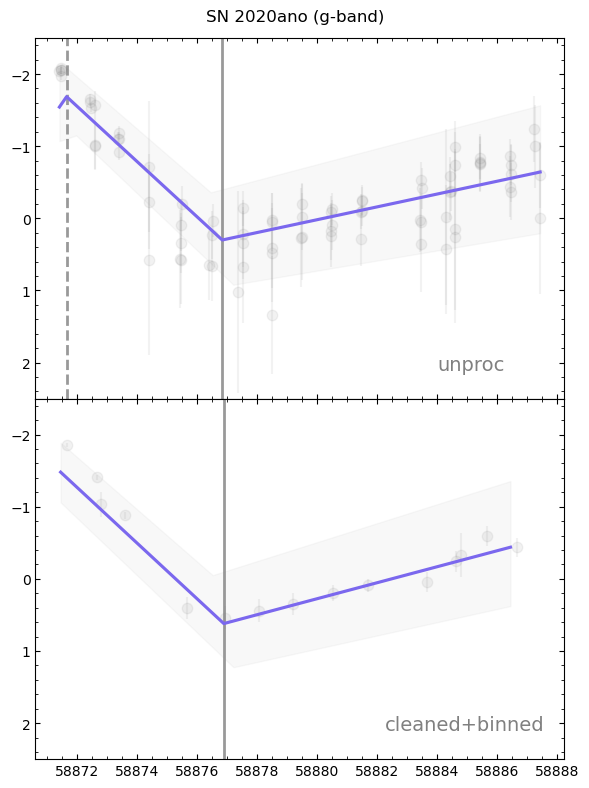

In [69]:
# #bestfit_df_old, bestfit_df_new

# # old MJD @ a2 = 58877.46900459984
# # new: MJD @ a2 = 58900.27552596666
# gridspec = dict(hspace=0.0)
# fig, ax = plt.subplots(2,1, figsize=(6,8),sharex=True,gridspec_kw=gridspec)

# #########plotting OLD
# g_df = sn20ano[(sn20ano['filter']=='ZTF_g') | (sn20ano['filter']=='c')]
# t_mjd = np.array(g_df['norm_t'])-15+old_a2_mjd
# x_plt = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)

# best = np.array(sn20ano_old_fit_g).T[0] #bestfit values
# lower_bound = np.array(sn20ano_old_fit_g).T[0] - np.array(sn20ano_old_fit_g).T[1] #50th ptile - diff_16ptile
# upper_bound = np.array(sn20ano_old_fit_g).T[0] + np.array(sn20ano_old_fit_g).T[2] #50th ptile + diff_84ptile

# #plotting mcmc results
# ax[0].plot(x_plt-15+old_a2_mjd, np.array([model(best, v, r1=True) for v in x_plt]), c='mediumslateblue', label='20ano_old', linewidth=2.25)# linestyle=ls[i])
# lower_curve = np.array([model(lower_bound, v, r1=True) for v in x_plt])
# upper_curve = np.array([model(upper_bound, v, r1=True) for v in x_plt])
# ax[0].fill_between(x_plt-15+old_a2_mjd, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)

# ax[0].axvline(bestfit_df_old[bestfit_df_old['SN_ID']==df_str]['a1_g'].iloc[0]-15+old_a2_mjd,
#               color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
# ax[0].axvline(bestfit_df_old[bestfit_df_old['SN_ID']==df_str]['a2_g'].iloc[0]-15+old_a2_mjd,
#               color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

# #plotting ztf data
# dets = (g_df['mag_err_all']<9999)
# uplims = ~dets
# x = np.array(g_df.loc[dets,'norm_t'])-15+old_a2_mjd
# y = np.array(g_df.loc[dets,'norm_m'])
# yerr = np.array(g_df.loc[dets,'mag_err_all'])
# xup, yup = np.array(g_df.loc[uplims,'norm_t'])-15+old_a2_mjd, np.array(g_df.loc[uplims,'norm_m'])
# ax[0].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0) #ztf errors,
# ax[0].scatter(xup, yup, linestyle='', marker='v', color='gray', alpha=0.1, s=65, zorder=0)

# ax[0].set_ylim(2.5,-2.5)
# # ax[0].set_title('Old MCMC Fits')

# ax[0].xaxis.set_minor_locator(AutoMinorLocator())
# ax[0].yaxis.set_minor_locator(AutoMinorLocator())
# ax[0].tick_params(which="both",top=True, labeltop=False, bottom=True, labelbottom=False, left=True, right=True, direction="in",zorder=0)

# plt.annotate('unproc',xy=(0.76,1.08),xycoords='axes fraction',color='gray',fontsize=14)



# # #######plotting NEW
# g_df = sn20ano_cl[(sn20ano_cl['filter']=='ZTF_g') | (sn20ano_cl['filter']=='c')]
# t_mjd = np.array(g_df['norm_t'])-15+new_a2_mjd
# x_plt = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)

# best = np.array(sn20ano_new_fit_g).T[0] #bestfit values
# lower_bound = np.array(sn20ano_new_fit_g).T[0] - np.array(sn20ano_new_fit_g).T[1] #50th ptile - diff_16ptile
# upper_bound = np.array(sn20ano_new_fit_g).T[0] + np.array(sn20ano_new_fit_g).T[2] #50th ptile + diff_84ptile

# #plotting mcmc results
# ax[1].plot(x_plt-15+new_a2_mjd, np.array([model(best, v, r1=False) for v in x_plt]), c='mediumslateblue', label='20ano_new', linewidth=2.25)# linestyle=ls[i])
# lower_curve = np.array([model(lower_bound, v, r1=False) for v in x_plt])
# upper_curve = np.array([model(upper_bound, v, r1=False) for v in x_plt])
# ax[1].fill_between(x_plt-15+new_a2_mjd, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)

# ax[1].axvline(bestfit_df_new[bestfit_df_new['SN_ID']==df_str]['a1_g'].iloc[0]-15+new_a2_mjd,
#                     color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
# ax[1].axvline(bestfit_df_new[bestfit_df_new['SN_ID']==df_str]['a2_g'].iloc[0]-15+new_a2_mjd,
#               color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

# #plotting ztf data
# dets = (g_df['mag_err_all']<9999)
# uplims = ~dets
# x = np.array(g_df.loc[dets,'norm_t'])-15+old_a2_mjd
# y = np.array(g_df.loc[dets,'norm_m'])
# yerr = np.array(g_df.loc[dets,'mag_err_all'])
# xup, yup = np.array(g_df.loc[uplims,'norm_t'])-15+old_a2_mjd, np.array(g_df.loc[uplims,'norm_m'])
# ax[1].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0) #ztf errors,
# ax[1].scatter(xup, yup, linestyle='', marker='v', color='gray', alpha=0.1, s=65, zorder=0)

# ax[1].set_ylim(2.5,-2.5)
# # ax[1].set_title('Cleaned+Averaged MCMC Fits')

# ax[1].xaxis.set_minor_locator(AutoMinorLocator())
# ax[1].yaxis.set_minor_locator(AutoMinorLocator())
# ax[1].tick_params(which="both",top=True, labeltop=False, bottom=True, labelbottom=True, left=True, right=True, direction="in",zorder=0)

# plt.annotate('cleaned+binned',xy=(0.66,0.08),xycoords='axes fraction',color='gray',fontsize=14)

# plt.suptitle('SN 2020ano (g-band)')
# plt.tight_layout()

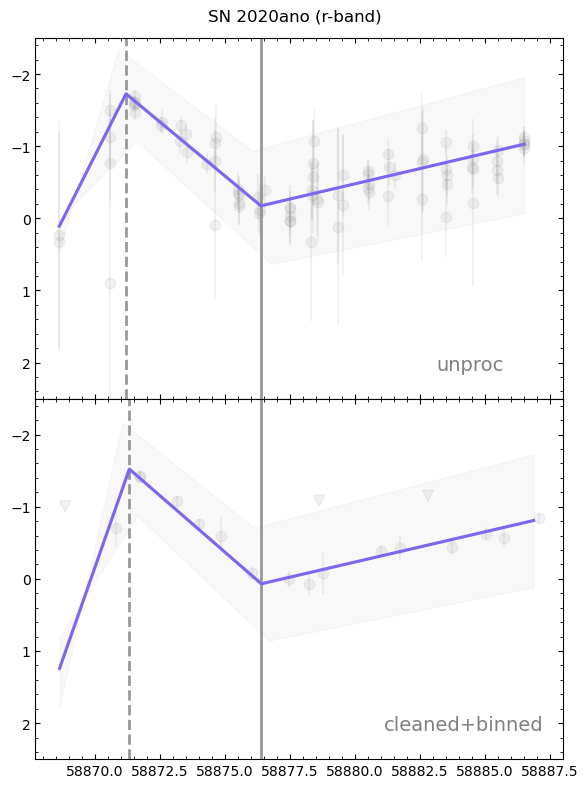

In [68]:
# #bestfit_df_old, bestfit_df_new

# gridspec = dict(hspace=0.0)
# fig, ax = plt.subplots(2,1, figsize=(6,8),sharex=True,gridspec_kw=gridspec)

# #########plotting OLD
# r_df = sn20ano[(sn20ano['filter']=='ZTF_r') | (sn20ano['filter']=='o')]
# t_mjd = np.array(r_df['norm_t'])-15+old_a2_mjd
# x_plt = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)

# best = np.array(sn20ano_old_fit_r).T[0] #bestfit values
# lower_bound = np.array(sn20ano_old_fit_r).T[0] - np.array(sn20ano_old_fit_r).T[1] #50th ptile - diff_16ptile
# upper_bound = np.array(sn20ano_old_fit_r).T[0] + np.array(sn20ano_old_fit_r).T[2] #50th ptile + diff_84ptile

# #plotting mcmc results
# ax[0].plot(x_plt-15+old_a2_mjd, np.array([model(best, v, r1=True) for v in x_plt]), c='mediumslateblue', label='20ano_old', linewidth=2.25)# linestyle=ls[i])
# lower_curve = np.array([model(lower_bound, v, r1=True) for v in x_plt])
# upper_curve = np.array([model(upper_bound, v, r1=True) for v in x_plt])
# ax[0].fill_between(x_plt-15+old_a2_mjd, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)

# ax[0].axvline(bestfit_df_old[bestfit_df_old['SN_ID']==df_str]['a1_r'].iloc[0]-15+old_a2_mjd,
#               color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
# ax[0].axvline(bestfit_df_old[bestfit_df_old['SN_ID']==df_str]['a2_r'].iloc[0]-15+old_a2_mjd,
#               color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

# #plotting ztf data
# dets = (r_df['mag_err_all']<9999)
# uplims = ~dets
# x = np.array(r_df.loc[dets,'norm_t'])-15+old_a2_mjd
# y = np.array(r_df.loc[dets,'norm_m'])
# yerr = np.array(r_df.loc[dets,'mag_err_all'])
# xup, yup = np.array(r_df.loc[uplims,'norm_t'])-15+old_a2_mjd, np.array(r_df.loc[uplims,'norm_m'])
# ax[0].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0) #ztf errors,
# ax[0].scatter(xup, yup, linestyle='', marker='v', color='gray', alpha=0.1, s=65,zorder=0)

# ax[0].set_ylim(2.5,-2.5)
# # ax[0].set_title('Old MCMC Fits')

# ax[0].xaxis.set_minor_locator(AutoMinorLocator())
# ax[0].yaxis.set_minor_locator(AutoMinorLocator())
# ax[0].tick_params(which="both",top=True, labeltop=False, bottom=True, labelbottom=False, left=True, right=True, direction="in",zorder=0)

# plt.annotate('unproc',xy=(0.76,1.08),xycoords='axes fraction',color='gray',fontsize=14)



# # #######plotting NEW
# r_df = sn20ano_cl[(sn20ano_cl['filter']=='ZTF_r') | (sn20ano_cl['filter']=='o')]
# t_mjd = np.array(r_df['norm_t'])-15+new_a2_mjd
# x_plt = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)

# best = np.array(sn20ano_new_fit_r).T[0] #bestfit values
# lower_bound = np.array(sn20ano_new_fit_r).T[0] - np.array(sn20ano_new_fit_r).T[1] #50th ptile - diff_16ptile
# upper_bound = np.array(sn20ano_new_fit_r).T[0] + np.array(sn20ano_new_fit_r).T[2] #50th ptile + diff_84ptile

# #plotting mcmc results
# ax[1].plot(x_plt-15+new_a2_mjd, np.array([model(best, v, r1=True) for v in x_plt]), c='mediumslateblue', label='20ano_new', linewidth=2.25)# linestyle=ls[i])
# lower_curve = np.array([model(lower_bound, v, r1=True) for v in x_plt])
# upper_curve = np.array([model(upper_bound, v, r1=True) for v in x_plt])
# ax[1].fill_between(x_plt-15+new_a2_mjd, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)

# ax[1].axvline(bestfit_df_new[bestfit_df_new['SN_ID']==df_str]['a1_r'].iloc[0]-15+new_a2_mjd,
#                     color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
# ax[1].axvline(bestfit_df_new[bestfit_df_new['SN_ID']==df_str]['a2_r'].iloc[0]-15+new_a2_mjd,
#               color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

# #plotting ztf data
# dets = (r_df['mag_err_all']<9999)
# uplims = ~dets
# x = np.array(r_df.loc[dets,'norm_t'])-15+old_a2_mjd
# y = np.array(r_df.loc[dets,'norm_m'])
# yerr = np.array(r_df.loc[dets,'mag_err_all'])
# xup, yup = np.array(r_df.loc[uplims,'norm_t'])-15+old_a2_mjd, np.array(r_df.loc[uplims,'norm_m'])
# ax[1].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0) #ztf errors,
# ax[1].scatter(xup, yup, linestyle='', marker='v', color='gray', alpha=0.1, s=65, zorder=0)

# ax[1].set_ylim(2.5,-2.5)
# # ax[1].set_title('Cleaned+Averaged MCMC Fits')

# ax[1].xaxis.set_minor_locator(AutoMinorLocator())
# ax[1].yaxis.set_minor_locator(AutoMinorLocator())
# ax[1].tick_params(which="both",top=True, labeltop=False, bottom=True, labelbottom=True, left=True, right=True, direction="in",zorder=0)

# plt.annotate('cleaned+binned',xy=(0.66,0.08),xycoords='axes fraction',color='gray',fontsize=14)

# plt.suptitle('SN 2020ano (r-band)')
# plt.tight_layout()

In [53]:
# def print_fit_comps(val):
#     print('old fits:\n16th, 50th, 84th')
#     print(round(bestfit_df_old[val].iloc[0]-low_err_df_old[val].iloc[0],3),
#           round(bestfit_df_old[val].iloc[0],3),
#           round(bestfit_df_old[val].iloc[0]+upp_err_df_old[val].iloc[0],3),
#           '\n')
#     print('new fits:\n16th, 50th, 84th')
#     print(round(bestfit_df_new[val].iloc[0]-low_err_df_new[val].iloc[0],3),
#           round(bestfit_df_new[val].iloc[0],3),
#           round(bestfit_df_new[val].iloc[0]+upp_err_df_new[val].iloc[0],3)
#           )

In [57]:
# print('PARAM: m1_r')
# print_fit_comps('m1_r') 
# print('\n')

# print('PARAM: m2_g')
# print_fit_comps('m2_g') 
# print('\n')

# print('PARAM: m2_r')
# print_fit_comps('m2_r') 
# print('\n')

# print('PARAM: m3_g')
# print_fit_comps('m3_g') 
# print('\n')

# print('PARAM: m3_r')
# print_fit_comps('m3_r') 
# print('\n')

# print('PARAM: a1_g')
# print_fit_comps('a1_g')
# print('\n')

# print('PARAM: a1_r')
# print_fit_comps('a1_r')
# print('\n')

# print('PARAM: a2_g')
# print_fit_comps('a2_g')
# print('\n')

# print('PARAM: a2_r')
# print_fit_comps('a2_r') 
# print('\n')

PARAM: m1_r
old fits:
16th, 50th, 84th
-1.225 -0.715 -0.363 

new fits:
16th, 50th, 84th
-1.623 -1.029 -0.563


PARAM: m2_g
old fits:
16th, 50th, 84th
0.359 0.383 0.395 

new fits:
16th, 50th, 84th
0.362 0.386 0.397


PARAM: m2_r
old fits:
16th, 50th, 84th
0.273 0.299 0.328 

new fits:
16th, 50th, 84th
0.287 0.313 0.341


PARAM: m3_g
old fits:
16th, 50th, 84th
-0.11 -0.089 -0.07 

new fits:
16th, 50th, 84th
-0.131 -0.111 -0.092


PARAM: m3_r
old fits:
16th, 50th, 84th
-0.097 -0.084 -0.072 

new fits:
16th, 50th, 84th
-0.095 -0.084 -0.073


PARAM: a1_g
old fits:
16th, 50th, 84th
9.018 9.181 9.501 

new fits:
16th, 50th, 84th
nan nan nan


PARAM: a1_r
old fits:
16th, 50th, 84th
8.428 8.723 9.122 

new fits:
16th, 50th, 84th
8.801 9.065 9.368


PARAM: a2_g
old fits:
16th, 50th, 84th
13.989 14.372 14.741 

new fits:
16th, 50th, 84th
14.268 14.638 14.96


PARAM: a2_r
old fits:
16th, 50th, 84th
13.585 13.917 14.32 

new fits:
16th, 50th, 84th
13.871 14.149 14.444


